This notebook is used to compare the Gasunie scenario's on the MR-station level. This notebook creates the boxplots comparing the different regions, the chloropleths and other not included plots.

In [1]:
# import packages

import numpy as np 
import pandas as pd  # provides interface for interacting with tabular data
import geopandas as gpd  # combines the capabilities of pandas and shapely for geospatial operations
from shapely.geometry import Point, Polygon, MultiPolygon  # for manipulating text data into geospatial shapes
from shapely import wkt  # stands for "well known text," allows for interchange across GIS programs
import rtree  # supports geospatial join

%matplotlib inline
import seaborn as sns
import matplotlib. pyplot as plt # for plotting graphs
import matplotlib.mlab as mlab # 
import matplotlib
plt.style.use('ggplot') # basic, but functional, plotstyle,
from matplotlib.pyplot import figure
matplotlib.rcParams['figure.figsize'] = (12,8)
import matplotlib.gridspec as GridSpec

# https://docs.bokeh.org/en/latest/docs/user_guide/categorical.html

from bokeh.io import output_file, show
from bokeh.models import ColumnDataSource, FactorRange
from bokeh.plotting import figure
from bokeh.palettes import Spectral, GnBu, PuBuGn, Set1
from bokeh.io import output_notebook
from bokeh.io import export_png

In [2]:
# LOAD DATA

#scenario = 'G1'
df1 = pd.read_csv("/Users/jaromirbogdanovski/Documents/Studie/EPA/Master Thesis/Igor Nikolic/Coding/Experimentation/Input data/Municipalities_26_08_experimentation_kw G1-table.csv", header = 6, sep = ",")

#scenario = 'G2'
df2 = pd.read_csv("/Users/jaromirbogdanovski/Documents/Studie/EPA/Master Thesis/Igor Nikolic/Coding/Experimentation/Input data/Municipalities_26_08_experimentation_kw G2-table.csv", header = 6, sep = ",")

#scenario = 'G3'
df3 = pd.read_csv("/Users/jaromirbogdanovski/Documents/Studie/EPA/Master Thesis/Igor Nikolic/Coding/Experimentation/Input data/Municipalities_26_08_experimentation_kw G3-table.csv", header = 6, sep = ",")

#scenario = 'G4'
df4 = pd.read_csv("/Users/jaromirbogdanovski/Documents/Studie/EPA/Master Thesis/Igor Nikolic/Coding/Experimentation/Input data/Municipalities_26_08_experimentation_kw G4-table.csv", header = 6, sep = ",")

#scenario = 'G5'
df5 = pd.read_csv("/Users/jaromirbogdanovski/Documents/Studie/EPA/Master Thesis/Igor Nikolic/Coding/Experimentation/Input data/Municipalities_26_08_experimentation_kw G5-table.csv", header = 6, sep = ",")

#scenario = 'G6'
df6 = pd.read_csv("/Users/jaromirbogdanovski/Documents/Studie/EPA/Master Thesis/Igor Nikolic/Coding/Experimentation/Input data/Municipalities_26_08_experimentation_kw G6-table.csv", header = 6, sep = ",")

#scenario = 'G7'
df7 = pd.read_csv("/Users/jaromirbogdanovski/Documents/Studie/EPA/Master Thesis/Igor Nikolic/Coding/Experimentation/Input data/Municipalities_26_08_experimentation_kw G7-table.csv", header = 6, sep = ",")

#scenario = 'G8'
df8 = pd.read_csv("/Users/jaromirbogdanovski/Documents/Studie/EPA/Master Thesis/Igor Nikolic/Coding/Experimentation/Input data/Municipalities_26_08_experimentation_kw G8-table.csv", header = 6, sep = ",")

# load CBS geodata
municipalities_input = gpd.read_file("/Users/jaromirbogdanovski/Documents/Studie/EPA/Master Thesis/Igor Nikolic/Coding/Data/Output/Gemeente/04_08/municipalities.shp")
# load capacities from 
MR_CAP = pd.read_excel('/Users/jaromirbogdanovski/Documents/Studie/EPA/Master Thesis/Igor Nikolic/Coding/Data/Output/Gemeente_excelGasunie/municipalities.xls', sheet_name='MaxCap')

In [3]:
filepath = '/Users/jaromirbogdanovski/Documents/Studie/EPA/Master Thesis/Igor Nikolic/Coding/Experimentation/Output/'
file = "GS_ANALYSIS" + "_" 

In [4]:
# concat dfs

df_all = pd.concat([df1.assign(scenario='G1'), df2.assign(scenario='G2'), df3.assign(scenario='G3'),
                   df4.assign(scenario='G4'), df5.assign(scenario='G5'), df6.assign(scenario='G6'),
                   df7.assign(scenario='G7'), df8.assign(scenario='G8')])

In [5]:
# melt dfs

#columns = ['output-nl-ng-kw', 'output-nl-gg-kw', 'output-nl-h2-kw', 'output-nl-e-kw', 'output-nl-h-kw']
#df_selected = df_all.loc[:,(columns) ].copy()
df_selected = df_all.copy()
df_selected['[run number]'] = df_all['[run number]']
df_selected['[step]'] = df_all['[step]'] + 2019
df_selected['scenario'] = df_all['scenario']
df_selected = df_selected[df_selected['[step]'] > 2019]
df_selected['Methane Gas'] = df_selected['output-nl-ng-kw'] + df_selected['output-nl-gg-kw']
df_selected['All Gas'] = df_selected['output-nl-ng-kw'] + df_selected['output-nl-gg-kw'] + df_selected['output-nl-h2-kw']

#df_selected = df_selected.rename(columns={"output-nl-ng-kw": "Natural Gas", "output-nl-gg-kw": "Green Gas", "output-nl-h2-kw": "Hydrogen Gas", "output-nl-e-kw": "Electricity", "output-nl-h-kw": "Heat"})

df_melted = df_selected.melt(id_vars = ['[run number]', '[step]', 'scenario'], var_name = 'output_type', value_name = 'output' )
df_mr = df_melted[(df_melted.output_type.str.contains('output-mr')) & df_melted.output_type.str.contains('-kw')
                 & (df_melted.output_type != 'output-mp-ng-kw') & (df_melted.output_type != 'output-mp-gg-kw')
                 & (df_melted.output_type != 'output-mp-h2-kw') & (df_melted.output_type != 'output-mp-e-kw')
                 & (df_melted.output_type != 'output-mp-h-kw')]

df_mr = df_mr[df_mr['[step]'] > 2019]
df_mr['MR'] = df_mr['output_type'].str.replace('output-mr-','').str.replace('-ng-kw','').str.replace('-gg-kw','').str.replace('-h2-kw','').str.replace('-e-kw','').str.replace('-h-kw','').str.capitalize()
df_mr['output_type'] = df_mr['output_type'].str[-5:]
df_mr = pd.merge(df_mr, MR_CAP, how = 'left', left_on = 'MR', right_on = 'Unique stations')
df_mr


[run number]  [step] scenario output_type   output              MR  \
0                    1    2020       G1       ng-kw   387980      Abbenbroek   
1                    1    2021       G1       ng-kw   365853      Abbenbroek   
2                    1    2022       G1       ng-kw   355166      Abbenbroek   
3                    1    2023       G1       ng-kw   335958      Abbenbroek   
4                    1    2024       G1       ng-kw   325837      Abbenbroek   
...                ...     ...      ...         ...      ...             ...   
10291995            99    2049       G8       -h-kw  55948.8  Zuideropgaande   
10291996            98    2050       G8       -h-kw  53377.1  Zuideropgaande   
10291997           100    2049       G8       -h-kw    46215  Zuideropgaande   
10291998            99    2050       G8       -h-kw    54307  Zuideropgaande   
10291999           100    2050       G8       -h-kw  45822.5  Zuideropgaande   

         Unique stations  MaxCapGasunieMW  RandomCapMW  
0             Abbenbroek         1143.074          NaN  
1             Abbenbroek         1143.074          NaN  
2             Abbenbroek         1143.074          NaN  
3             Abbenbroek         1143.074          NaN  
4             Abbenbroek         1143.074          NaN  
...                  ...              ...          ...  
10291995  Zuideropgaande         1187.094          NaN  
10291996  Zuideropgaande         1187.094          NaN  
10291997  Zuideropgaande         1187.094          NaN  
10291998  Zuideropgaande         1187.094          NaN  
10291999  Zuideropgaande         1187.094          NaN  

[10292000 rows x 9 columns]

In [6]:
def output_t0(row, df):
    output_t0 = df['output'][(df['MR'] == row.MR) & (df['scenario'] == row['scenario']) & (df['[step]'] == 2020) & (df['output_type'] == row.output_type)].mean()
    return output_t0

In [7]:
# methane gas df
df_mr_mg = pd.concat([df_mr[df_mr.output_type == 'ng-kw'], df_mr[df_mr.output_type == 'gg-kw']])
df_mr_mg[['output']] = df_mr_mg[['output']].apply(pd.to_numeric).copy()
df_mr_mg = df_mr_mg.groupby(['[step]', 'scenario', 'MR', 'output_type', 'MaxCapGasunieMW'], as_index=False).mean()


df_mr_mg = df_mr_mg.groupby(['[step]', 'scenario', 'MR'], as_index=False).sum()
df_mr_mg = df_mr_mg.drop('[run number]', 1)
df_mr_mg['output_type'] = 'Methane Gas'
df_mr_mg

[step] scenario              MR  MaxCapGasunieMW        output  \
0        2020       G1      Abbenbroek         2286.148  3.879801e+05   
1        2020       G1    Achterdrempt          754.162  1.443474e+05   
2        2020       G1         Alkmaar         2083.162  8.035593e+05   
3        2020       G1         Angerlo         4499.308  2.355829e+06   
4        2020       G1       Apeldoorn         1737.058  8.304577e+05   
...       ...      ...             ...              ...           ...   
20579    2050       G8      Zaltbommel         3580.058  1.263122e+05   
20580    2050       G8           Zegge         2655.232  1.004040e+05   
20581    2050       G8     Zoeterwoude         4273.364  2.352115e+05   
20582    2050       G8   Zuid-kraayert         1614.370  4.106669e+04   
20583    2050       G8  Zuideropgaande         2374.188  1.046793e+05   

       RandomCapMW  output_type  
0              0.0  Methane Gas  
1              0.0  Methane Gas  
2              0.0  Methane Gas  
3              0.0  Methane Gas  
4              0.0  Methane Gas  
...            ...          ...  
20579          0.0  Methane Gas  
20580          0.0  Methane Gas  
20581          0.0  Methane Gas  
20582          0.0  Methane Gas  
20583          0.0  Methane Gas  

[20584 rows x 7 columns]

In [8]:
df_mr_mg['output_t0'] = df_mr_mg.apply(lambda row: output_t0(row, df_mr_mg), axis = 1)
df_mr_mg['rel_output'] = df_mr_mg['output'] / df_mr_mg['output_t0']
df_mr_mg['overcapacity'] = df_mr_mg['output_t0'] - df_mr_mg['output']
df_mr_mg['Gasunie_overcapacity'] = (df_mr_mg['MaxCapGasunieMW'] * 1000) - df_mr_mg['output']
df_mr_mg = df_mr_mg.rename(columns={'[step]':'Year'})

In [9]:
# all gas df
df_mr_ag = pd.concat([df_mr[df_mr.output_type == 'ng-kw'], df_mr[df_mr.output_type == 'gg-kw'],df_mr[df_mr.output_type == 'h2-kw']])
df_mr_ag[['output']] = df_mr_ag[['output']].apply(pd.to_numeric).copy()
df_mr_ag = df_mr_ag.groupby(['[step]', 'scenario', 'MR', 'output_type', 'MaxCapGasunieMW'], as_index=False).mean()

df_mr_ag = df_mr_ag.groupby(['[step]', 'scenario', 'MR', 'MaxCapGasunieMW'], as_index=False).sum()
df_mr_ag = df_mr_ag.drop('[run number]', 1)
df_mr_ag['output_type'] = 'All Gas'
df_mr_ag

[step] scenario              MR  MaxCapGasunieMW        output  \
0        2020       G1      Abbenbroek         1143.074  3.879801e+05   
1        2020       G1    Achterdrempt          377.081  1.443474e+05   
2        2020       G1         Alkmaar         1041.581  8.035593e+05   
3        2020       G1         Angerlo         2249.654  2.355829e+06   
4        2020       G1       Apeldoorn          868.529  8.304577e+05   
...       ...      ...             ...              ...           ...   
20579    2050       G8      Zaltbommel         1790.029  1.263122e+05   
20580    2050       G8           Zegge         1327.616  1.004040e+05   
20581    2050       G8     Zoeterwoude         2136.682  2.352115e+05   
20582    2050       G8   Zuid-kraayert          807.185  4.106669e+04   
20583    2050       G8  Zuideropgaande         1187.094  1.046793e+05   

       RandomCapMW output_type  
0              0.0     All Gas  
1              0.0     All Gas  
2              0.0     All Gas  
3              0.0     All Gas  
4              0.0     All Gas  
...            ...         ...  
20579          0.0     All Gas  
20580          0.0     All Gas  
20581          0.0     All Gas  
20582          0.0     All Gas  
20583          0.0     All Gas  

[20584 rows x 7 columns]

In [10]:
df_mr_ag['output_t0'] = df_mr_ag.apply(lambda row: output_t0(row, df_mr_ag), axis = 1)
df_mr_ag['rel_output'] = df_mr_ag['output'] / df_mr_ag['output_t0']
df_mr_ag['overcapacity'] = df_mr_ag['output_t0'] - df_mr_ag['output']
df_mr_ag['Gasunie_overcapacity'] = (df_mr_ag['MaxCapGasunieMW'] * 1000) - df_mr_ag['output']
df_mr_ag = df_mr_ag.rename(columns={'[step]':'Year'})

In [11]:
df_mr_mg_ag = pd.concat([df_mr_ag, df_mr_mg])
df_mr_mg_ag

Year scenario              MR  MaxCapGasunieMW        output  \
0      2020       G1      Abbenbroek         1143.074  3.879801e+05   
1      2020       G1    Achterdrempt          377.081  1.443474e+05   
2      2020       G1         Alkmaar         1041.581  8.035593e+05   
3      2020       G1         Angerlo         2249.654  2.355829e+06   
4      2020       G1       Apeldoorn          868.529  8.304577e+05   
...     ...      ...             ...              ...           ...   
20579  2050       G8      Zaltbommel         3580.058  1.263122e+05   
20580  2050       G8           Zegge         2655.232  1.004040e+05   
20581  2050       G8     Zoeterwoude         4273.364  2.352115e+05   
20582  2050       G8   Zuid-kraayert         1614.370  4.106669e+04   
20583  2050       G8  Zuideropgaande         2374.188  1.046793e+05   

       RandomCapMW  output_type     output_t0  rel_output  overcapacity  \
0              0.0      All Gas  3.879801e+05    1.000000  0.000000e+00   
1              0.0      All Gas  1.443474e+05    1.000000  0.000000e+00   
2              0.0      All Gas  8.035593e+05    1.000000  0.000000e+00   
3              0.0      All Gas  2.355829e+06    1.000000  0.000000e+00   
4              0.0      All Gas  8.304577e+05    1.000000  0.000000e+00   
...            ...          ...           ...         ...           ...   
20579          0.0  Methane Gas  7.499251e+05    0.168433  6.236128e+05   
20580          0.0  Methane Gas  9.547548e+05    0.105162  8.543509e+05   
20581          0.0  Methane Gas  1.375470e+06    0.171005  1.140258e+06   
20582          0.0  Methane Gas  5.480022e+05    0.074939  5.069355e+05   
20583          0.0  Methane Gas  6.616627e+05    0.158206  5.569834e+05   

       Gasunie_overcapacity  
0              7.550939e+05  
1              2.327336e+05  
2              2.380217e+05  
3             -1.061747e+05  
4              3.807134e+04  
...                     ...  
20579          3.453746e+06  
20580          2.554828e+06  
20581          4.038152e+06  
20582          1.573303e+06  
20583          2.269509e+06  

[41168 rows x 11 columns]

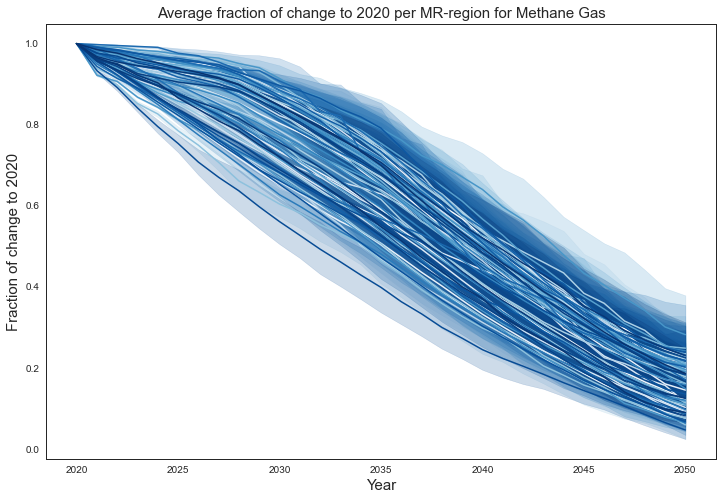

In [494]:
# lineplot with all MR's from 2020 to 2050 --> MG fraction of change to t0
# note: you lose outlier information on scenarios as bandwiths are based on AVERAGES instead of outliers

sns.set_style('white')

sns.lineplot(
    data=df_mr_mg, x="Year", y="rel_output",
    hue="MR", style="output_type", ci=95, legend = False, palette = 'Blues')
plt.ylabel('Fraction of change to 2020', fontsize=15)
plt.xlabel('Year', fontsize=15)
title = 'Average fraction of change to 2020 per MR-region for Methane Gas'
plt.title(title, fontsize=15)

plotfile = filepath + file + title
plt.savefig(plotfile, dpi=400)

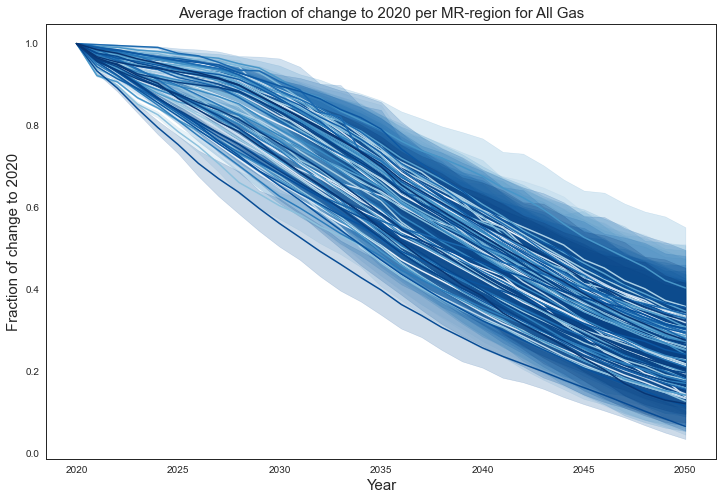

In [495]:
# lineplot with all MR's from 2020 to 2050 --> AG fraction of change to t0
# note: you lose outlier information on scenarios as bandwiths are based on AVERAGES instead of outliers

sns.set_style('white')

sns.lineplot(
    data=df_mr_ag, x="Year", y="rel_output",
    hue="MR", style="output_type", ci=95, legend = False, palette = 'Blues')
plt.ylabel('Fraction of change to 2020', fontsize=15)
plt.xlabel('Year', fontsize=15)
title = 'Average fraction of change to 2020 per MR-region for All Gas'
plt.title(title, fontsize=15)

plotfile = filepath + file + title
plt.savefig(plotfile, dpi=400)

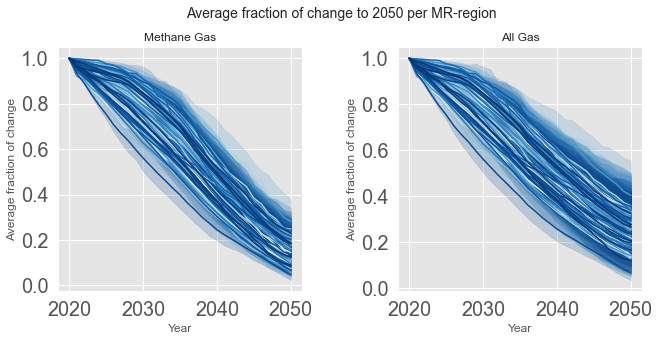

In [579]:
fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize = (10,5))
fig.tight_layout(pad=4)
title = 'Average fraction of change to 2050 per MR-region'
fig.suptitle(title, fontsize = 14)

sns.lineplot(ax=ax1,
    data=df_mr_mg, x="Year", y="rel_output",
    hue="MR", style="output_type", ci=95, legend = False, palette = 'Blues')
ax1.set(ylabel='Average fraction of change', xlabel = 'Year')
ax1.set_title('Methane Gas', fontsize = 12)

sns.lineplot(ax=ax2,
    data=df_mr_ag, x="Year", y="rel_output",
    hue="MR", style="output_type", ci=95, legend = False, palette = 'Blues')
ax2.set(ylabel='Average fraction of change', xlabel = 'Year')
ax2.set_title('All Gas', fontsize = 12)

plotfile = filepath + file + title
plt.savefig(plotfile, dpi=400)

Text(0.5, 1.0, 'Average fraction of change to 2020 per MR-region')

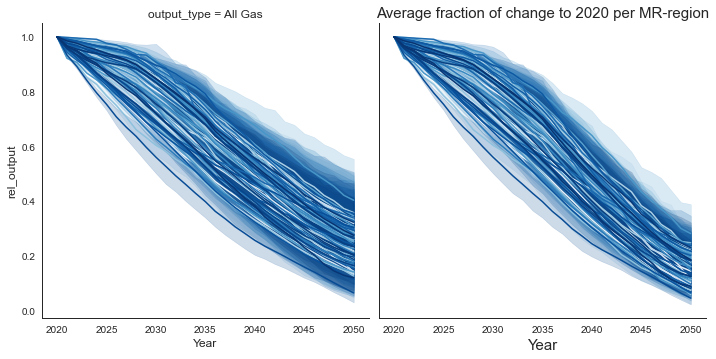

In [490]:
# lineplot with all MR's from 2020 to 2050 --> MG+AG fraction of change to t0
# note: you lose outlier information on scenarios as bandwiths are based on AVERAGES instead of outliers

sns.set_style('white')

sns.relplot(
    data=df_mr_mg_ag, x="Year", y="rel_output",
    hue="MR", col="output_type",
    ci=95, legend = False, palette = 'Blues', kind='line')
plt.ylabel('Fraction of change to 2020', fontsize=15)
plt.xlabel('Year', fontsize=15)
title = 'Average fraction of change to 2020 per MR-region'
plt.title(title, fontsize=15)

#plotfile = filepath + file + title
#plt.savefig()

Text(0.5, 6.799999999999994, 'Year')

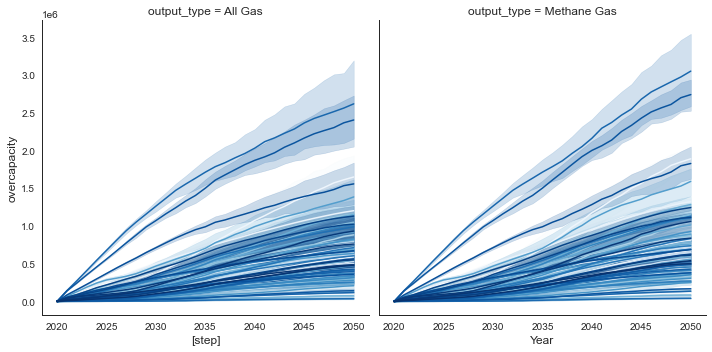

In [350]:
# plot overcapacity

sns.set_style('white')

sns.relplot(
    data=df_mr_mg_ag, x="[step]", y="overcapacity",
    hue="MR", col="output_type",
    ci=95, legend = False, palette = 'Blues', kind='line')
plt.ylabel('Fraction of change to 2020')
plt.xlabel('Year')

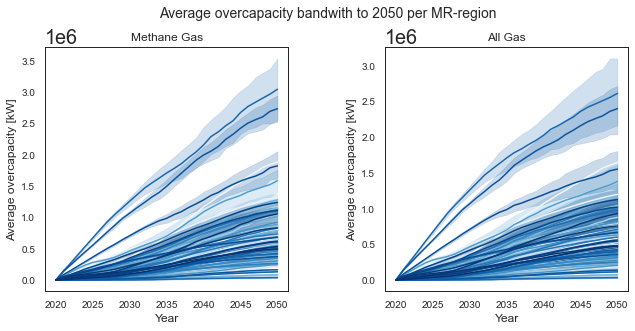

In [586]:
# OVERCAPACITY TEXT
sns.set_style('white')
fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize = (10,5))
fig.tight_layout(pad=4)
title = 'Average overcapacity bandwith to 2050 per MR-region'
fig.suptitle(title, fontsize = 14)

sns.lineplot(ax=ax1,
    data=df_mr_mg, x="Year", y="overcapacity",
    hue="MR", style="output_type", ci=95, legend = False, palette = 'Blues')
ax1.set(ylabel='Average overcapacity [kW]', xlabel = 'Year')
ax1.set_title('Methane Gas', fontsize = 12)
#plt.xticks(fontsize=10)
#plt.yticks(fontsize=10)
ax1.tick_params(labelsize=10)

sns.lineplot(ax=ax2,
    data=df_mr_ag, x="Year", y="overcapacity",
    hue="MR", style="output_type", ci=95, legend = False, palette = 'Blues')
ax2.set(ylabel='Average overcapacity [kW]', xlabel = 'Year')
ax2.set_title('All Gas', fontsize = 12)
#plt.xticks(fontsize=10)
#plt.yticks(fontsize=10)
ax2.tick_params(labelsize=10)

plotfile = filepath + file + title
plt.savefig(plotfile, dpi=400)

In [351]:
# top 5 average overcapacity Methane Gas
df_mr_mg.groupby('MR').mean().sort_values(by='overcapacity', ascending=False)[:5]

[step]  MaxCapGasunieMW        output  RandomCapMW     output_t0  \
MR                                                                              
Sloten         2035         2917.674  2.290232e+06          0.0  3.959139e+06   
Vlaardingen    2035         1972.105  1.679530e+06          0.0  3.168446e+06   
Voorburg       2035         1770.221  1.263248e+06          0.0  2.239330e+06   
Angerlo        2035         2249.654  1.526254e+06          0.0  2.351417e+06   
Odijk          2035         1366.453  1.215502e+06          0.0  1.999108e+06   

             rel_output  overcapacity  Gasunie_overcapacity  
MR                                                           
Sloten         0.578393  1.668906e+06         627441.565568  
Vlaardingen    0.529969  1.488916e+06         292575.321318  
Voorburg       0.564058  9.760817e+05         506973.211023  
Angerlo        0.648973  8.251623e+05         723399.619059  
Odijk          0.607961  7.836067e+05         150951.291003

In [352]:
# top 5 average overcapacity All Gas
df_mr_ag.groupby('MR').mean().sort_values(by='overcapacity', ascending=False)[:5]

[step]  MaxCapGasunieMW        output  RandomCapMW     output_t0  \
MR                                                                              
Sloten         2035         2917.674  2.402125e+06          0.0  3.959139e+06   
Vlaardingen    2035         1972.105  1.773886e+06          0.0  3.168446e+06   
Voorburg       2035         1770.221  1.333082e+06          0.0  2.239330e+06   
Angerlo        2035         2249.654  1.594940e+06          0.0  2.351417e+06   
Odijk          2035         1366.453  1.278118e+06          0.0  1.999108e+06   

             rel_output  overcapacity  Gasunie_overcapacity  
MR                                                           
Sloten         0.606665  1.557014e+06         515549.340879  
Vlaardingen    0.559739  1.394560e+06         198218.730668  
Voorburg       0.595250  9.062473e+05         437138.828474  
Angerlo        0.678156  7.564772e+05         654714.486073  
Odijk          0.639277  7.209904e+05          88335.010242

Text(0.5, 6.799999999999994, 'Year')

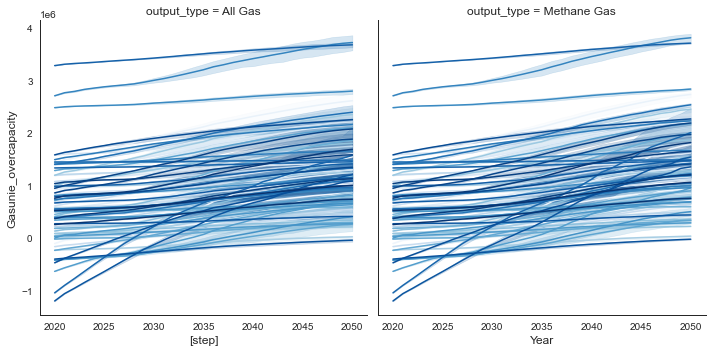

In [353]:
# plot GASUNIE overcapacity

sns.set_style('white')

sns.relplot(
    data=df_mr_mg_ag, x="[step]", y="Gasunie_overcapacity",
    hue="MR", col="output_type",
    ci=95, legend = False, palette = 'Blues', kind='line')
plt.ylabel('Fraction of change to 2020')
plt.xlabel('Year')

Text(0.5, 20.846874999999983, 'Year')

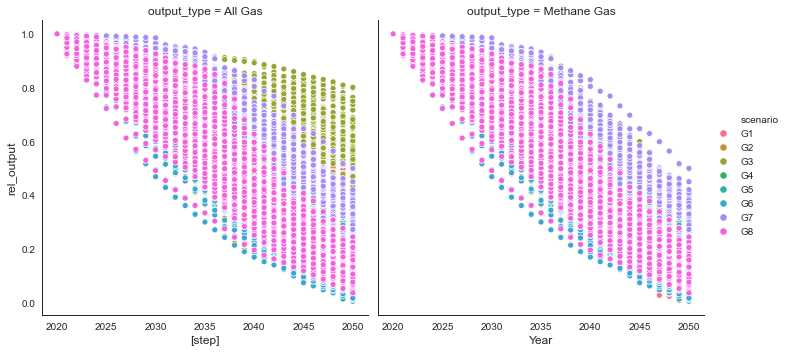

In [354]:
# scatter with all MR's from 2020 to 2050 --> MG+AG fraction of change to t0
# note: you lose outlier information on scenarios as bandwiths are based on AVERAGES instead of outliers

sns.set_style('white')

sns.relplot(
    data=df_mr_mg_ag, x="[step]", y="rel_output",
    hue="scenario", col="output_type",
    ci=95, legend = 'full', kind='scatter')
plt.ylabel('Fraction of change to 2020')
plt.xlabel('Year')

In [14]:
df_mr_mg_ag

Year scenario              MR  MaxCapGasunieMW        output  \
0      2020       G1      Abbenbroek         1143.074  3.879801e+05   
1      2020       G1    Achterdrempt          377.081  1.443474e+05   
2      2020       G1         Alkmaar         1041.581  8.035593e+05   
3      2020       G1         Angerlo         2249.654  2.355829e+06   
4      2020       G1       Apeldoorn          868.529  8.304577e+05   
...     ...      ...             ...              ...           ...   
20579  2050       G8      Zaltbommel         3580.058  1.263122e+05   
20580  2050       G8           Zegge         2655.232  1.004040e+05   
20581  2050       G8     Zoeterwoude         4273.364  2.352115e+05   
20582  2050       G8   Zuid-kraayert         1614.370  4.106669e+04   
20583  2050       G8  Zuideropgaande         2374.188  1.046793e+05   

       RandomCapMW  output_type     output_t0  rel_output  overcapacity  \
0              0.0      All Gas  3.879801e+05    1.000000  0.000000e+00   
1              0.0      All Gas  1.443474e+05    1.000000  0.000000e+00   
2              0.0      All Gas  8.035593e+05    1.000000  0.000000e+00   
3              0.0      All Gas  2.355829e+06    1.000000  0.000000e+00   
4              0.0      All Gas  8.304577e+05    1.000000  0.000000e+00   
...            ...          ...           ...         ...           ...   
20579          0.0  Methane Gas  7.499251e+05    0.168433  6.236128e+05   
20580          0.0  Methane Gas  9.547548e+05    0.105162  8.543509e+05   
20581          0.0  Methane Gas  1.375470e+06    0.171005  1.140258e+06   
20582          0.0  Methane Gas  5.480022e+05    0.074939  5.069355e+05   
20583          0.0  Methane Gas  6.616627e+05    0.158206  5.569834e+05   

       Gasunie_overcapacity  
0              7.550939e+05  
1              2.327336e+05  
2              2.380217e+05  
3             -1.061747e+05  
4              3.807134e+04  
...                     ...  
20579          3.453746e+06  
20580          2.554828e+06  
20581          4.038152e+06  
20582          1.573303e+06  
20583          2.269509e+06  

[41168 rows x 11 columns]

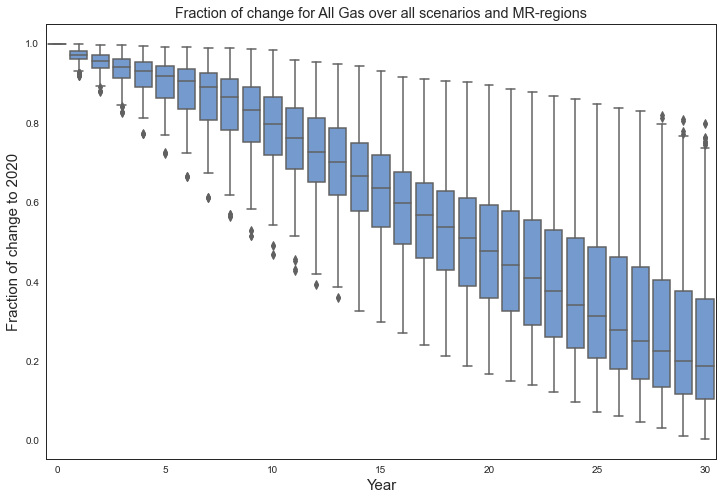

<Figure size 864x576 with 0 Axes>

In [14]:
# boxplot of the above
import matplotlib.ticker as ticker
title = 'Fraction of change for All Gas over all scenarios and MR-regions'
sns.set_style('white')

ax = sns.boxplot(
    data=df_mr_ag, x="Year", y="rel_output", color = '#69d')
plt.ylabel('Fraction of change to 2020', fontsize = 15)
plt.xlabel('Year', fontsize = 15)
plt.title(title)
ax.xaxis.set_major_locator(ticker.MultipleLocator(5))
ax.xaxis.set_major_formatter(ticker.ScalarFormatter())
plt.show()
plotfile = filepath + file + title
plt.savefig(plotfile, dpi=400)

In [607]:
# bandwith analysis

df_mr_ag[df_mr_ag['Year'] == 2050].sort_values(by='rel_output')

Year scenario              MR  MaxCapGasunieMW         output  \
20316  2050       G5      Simpelveld         1500.000     204.675104   
20369  2050       G6  Krimpenerwaard          385.501    3516.512993   
20394  2050       G6        Rijswijk         2302.654   11709.263494   
20409  2050       G6           Weesp         2303.516   11195.547747   
20406  2050       G6     Vlaardingen         1972.105   54996.641971   
...     ...      ...             ...              ...            ...   
20111  2050       G3         Groenlo         1039.433  724826.096151   
20150  2050       G3      Simpelveld         1500.000   38617.330555   
20125  2050       G3          Melick          623.353   83110.456513   
20112  2050       G3       Gronsveld          677.427   74341.441097   
20136  2050       G3          Oostum          852.739  278985.303403   

       RandomCapMW output_type     output_t0  rel_output  overcapacity  \
20316          0.0     All Gas  5.059137e+04    0.004046  5.038669e+04   
20369          0.0     All Gas  3.401811e+05    0.010337  3.366646e+05   
20394          0.0     All Gas  8.056762e+05    0.014533  7.939669e+05   
20409          0.0     All Gas  7.147293e+05    0.015664  7.035338e+05   
20406          0.0     All Gas  3.158580e+06    0.017412  3.103584e+06   
...            ...         ...           ...         ...           ...   
20111          0.0     All Gas  9.521907e+05    0.761219  2.273646e+05   
20150          0.0     All Gas  5.059137e+04    0.763319  1.197404e+04   
20125          0.0     All Gas  1.087107e+05    0.764510  2.560026e+04   
20112          0.0     All Gas  9.328787e+04    0.796904  1.894643e+04   
20136          0.0     All Gas  3.483776e+05    0.800813  6.939227e+04   

       Gasunie_overcapacity  
20316          1.499795e+06  
20369          3.819845e+05  
20394          2.290945e+06  
20409          2.292320e+06  
20406          1.917108e+06  
...                     ...  
20111          3.146069e+05  
20150          1.461383e+06  
20125          5.402425e+05  
20112          6.030856e+05  
20136          5.737537e+05  

[664 rows x 11 columns]

Text(0.5, 1.0, 'All Gas')

/Users/jaromirbogdanovski/anaconda3/lib/python3.6/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


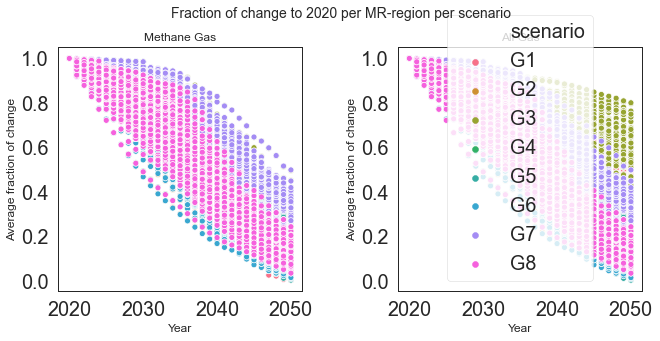

In [596]:
fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize = (10,5))
fig.tight_layout(pad=4)
title = 'Fraction of change to 2020 per MR-region per scenario'
fig.suptitle(title, fontsize = 14)

sns.scatterplot(ax=ax1,
    data=df_mr_mg, x="Year", y="rel_output",
    hue="scenario",
    ci=95, legend = False)
ax1.set(ylabel='Average fraction of change', xlabel = 'Year')
ax1.set_title('Methane Gas', fontsize = 12)

sns.scatterplot(ax=ax2,
    data=df_mr_ag, x="Year", y="rel_output",
    hue="scenario",
    ci=95, legend = 'full')
ax2.set(ylabel='Average fraction of change', xlabel = 'Year')
ax2.set_title('All Gas', fontsize = 12)

#plotfile = filepath + file + title
#plt.savefig(plotfile, dpi=400)

In [387]:
df_mr_ag[df_mr_ag['[step]'] == 2050].sort_values(by='rel_output', ascending=True)

[step] scenario              MR  MaxCapGasunieMW         output  \
20316    2050       G5      Simpelveld         1500.000     204.675104   
20369    2050       G6  Krimpenerwaard          385.501    3516.512993   
20394    2050       G6        Rijswijk         2302.654   11709.263494   
20409    2050       G6           Weesp         2303.516   11195.547747   
20406    2050       G6     Vlaardingen         1972.105   54996.641971   
...       ...      ...             ...              ...            ...   
20111    2050       G3         Groenlo         1039.433  724826.096151   
20150    2050       G3      Simpelveld         1500.000   38617.330555   
20125    2050       G3          Melick          623.353   83110.456513   
20112    2050       G3       Gronsveld          677.427   74341.441097   
20136    2050       G3          Oostum          852.739  278985.303403   

       RandomCapMW output_type     output_t0  rel_output  overcapacity  \
20316          0.0     All Gas  5.059137e+04    0.004046  5.038669e+04   
20369          0.0     All Gas  3.401811e+05    0.010337  3.366646e+05   
20394          0.0     All Gas  8.056762e+05    0.014533  7.939669e+05   
20409          0.0     All Gas  7.147293e+05    0.015664  7.035338e+05   
20406          0.0     All Gas  3.158580e+06    0.017412  3.103584e+06   
...            ...         ...           ...         ...           ...   
20111          0.0     All Gas  9.521907e+05    0.761219  2.273646e+05   
20150          0.0     All Gas  5.059137e+04    0.763319  1.197404e+04   
20125          0.0     All Gas  1.087107e+05    0.764510  2.560026e+04   
20112          0.0     All Gas  9.328787e+04    0.796904  1.894643e+04   
20136          0.0     All Gas  3.483776e+05    0.800813  6.939227e+04   

       Gasunie_overcapacity  
20316          1.499795e+06  
20369          3.819845e+05  
20394          2.290945e+06  
20409          2.292320e+06  
20406          1.917108e+06  
...                     ...  
20111          3.146069e+05  
20150          1.461383e+06  
20125          5.402425e+05  
20112          6.030856e+05  
20136          5.737537e+05  

[664 rows x 11 columns]

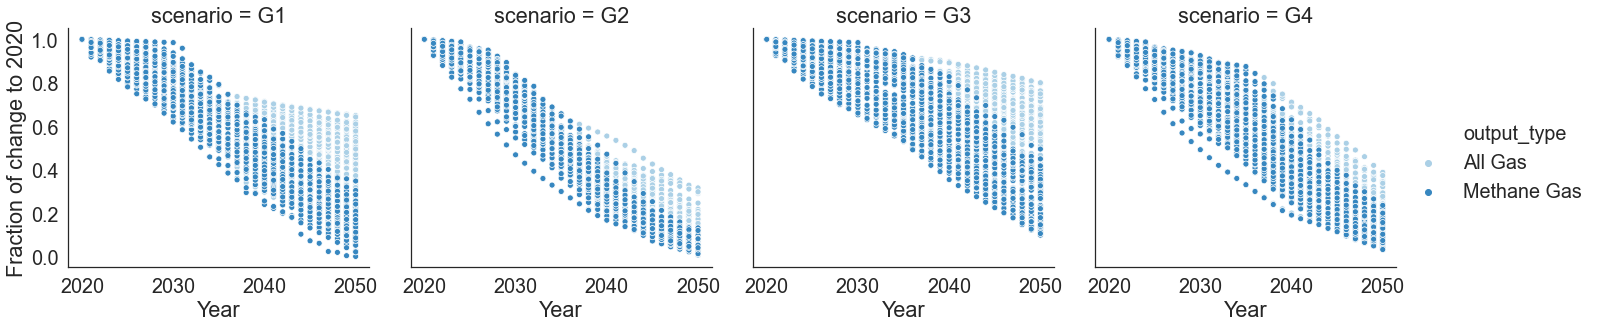

In [547]:
# scatter with all MR's from 2020 to 2050 --> MG+AG fraction of change to t0
# note: you lose outlier information on scenarios as bandwiths are based on AVERAGES instead of outliers

#sns.set_style('white')
sns.set(font_scale=1.8, style='white')

p = sns.relplot(
    data=df_mr_mg_ag[(df_mr_mg_ag['scenario'] == 'G1') | 
                    (df_mr_mg_ag['scenario'] == 'G2') | 
                    (df_mr_mg_ag['scenario'] == 'G3') | 
                    (df_mr_mg_ag['scenario'] == 'G4')]
    , x="Year", y="rel_output",
    hue="output_type", col="scenario",
    ci=95, legend = 'full', kind='scatter',
    palette = 'Blues')
p.set_axis_labels("Year", "Fraction of change to 2020")
title= 'Fraction of change to 2020 per MR difference per scenario (Hydrogen available in 2035)'
#p.fig.suptitle(title, y=1.05)

plotfile = filepath + file + title
plt.savefig(plotfile, dpi=400)

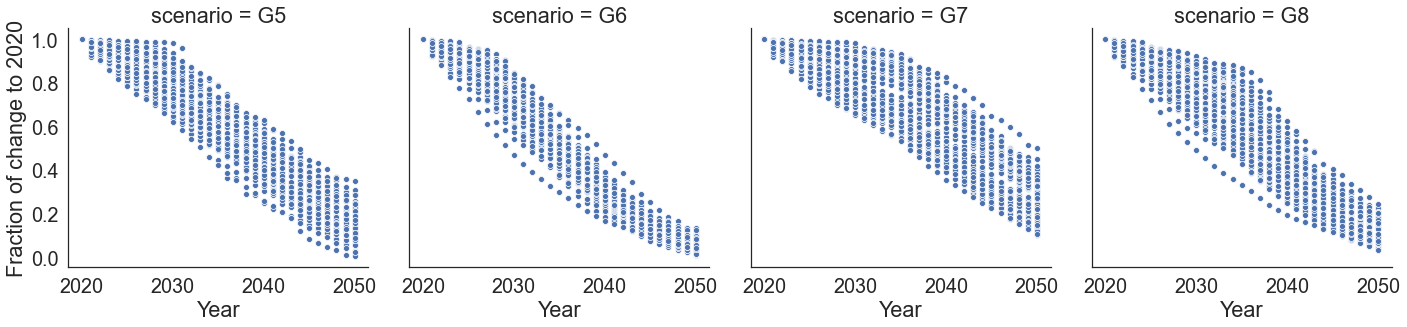

In [548]:
# scatter with all MR's from 2020 to 2050 --> MG+AG fraction of change to t0
# note: you lose outlier information on scenarios as bandwiths are based on AVERAGES instead of outliers

#sns.set_style('white')
sns.set(font_scale=1.8, style='white')

p = sns.relplot(
    data=df_mr_mg_ag[(df_mr_mg_ag['scenario'] == 'G5') | 
                    (df_mr_mg_ag['scenario'] == 'G6') | 
                    (df_mr_mg_ag['scenario'] == 'G7') | 
                    (df_mr_mg_ag['scenario'] == 'G8')]
    , x="Year", y="rel_output",
     col="scenario",
    ci=95, legend = 'full', kind='scatter',
    palette='Blues')
p.set_axis_labels("Year", "Fraction of change to 2020")
title= 'Fraction of change to 2020 per MR difference per scenario (Hydrogen not available)'
#p.fig.suptitle(title, y=1.05)

plotfile = filepath + file + title
plt.savefig(plotfile, dpi=400)

In [356]:
# top 5 sharpest decline Methane Gas
df_mr_mg.groupby('MR').mean().sort_values(by='rel_output', ascending=True)[:5]

[step]  MaxCapGasunieMW         output  RandomCapMW  \
MR                                                                      
Weesp               2035         2303.516  314050.245018          0.0   
Krimpenerwaard      2035          385.501  161071.565490          0.0   
Rijswijk            2035         2302.654  399407.308645          0.0   
Vondelingenplaat    2035            7.380  200874.725219          0.0   
Gilze               2035         1104.361  455726.701897          0.0   

                      output_t0  rel_output   overcapacity  \
MR                                                           
Weesp             718023.133746    0.437152  403972.888728   
Krimpenerwaard    340724.120646    0.472662  179652.555156   
Rijswijk          808034.453839    0.494198  408627.145194   
Vondelingenplaat  405990.580067    0.494690  205115.854848   
Gilze             917438.457216    0.496680  461711.755319   

                  Gasunie_overcapacity  
MR                                      
Weesp                     1.989466e+06  
Krimpenerwaard            2.244294e+05  
Rijswijk                  1.903247e+06  
Vondelingenplaat         -1.934947e+05  
Gilze                     6.486343e+05

In [357]:
# top 5 sharpest decline All Gas
df_mr_ag.groupby('MR').mean().sort_values(by='rel_output', ascending=True)[:5]

[step]  MaxCapGasunieMW         output  RandomCapMW  \
MR                                                                      
Weesp               2035         2303.516  318574.682430          0.0   
Krimpenerwaard      2035          385.501  167685.497013          0.0   
Vondelingenplaat    2035            7.380  206589.205301          0.0   
Gilze               2035         1104.361  471579.187303          0.0   
Oosteind            2035          740.530  382767.823885          0.0   

                      output_t0  rel_output   overcapacity  \
MR                                                           
Weesp             718023.133746    0.443434  399448.451316   
Krimpenerwaard    340724.120646    0.492054  173038.623634   
Vondelingenplaat  405990.580067    0.508743  199401.374766   
Gilze             917438.457216    0.513934  445859.269913   
Oosteind          738271.672561    0.518281  355503.848676   

                  Gasunie_overcapacity  
MR                                      
Weesp                     1.984941e+06  
Krimpenerwaard            2.178155e+05  
Vondelingenplaat         -1.992092e+05  
Gilze                     6.327818e+05  
Oosteind                  3.577622e+05

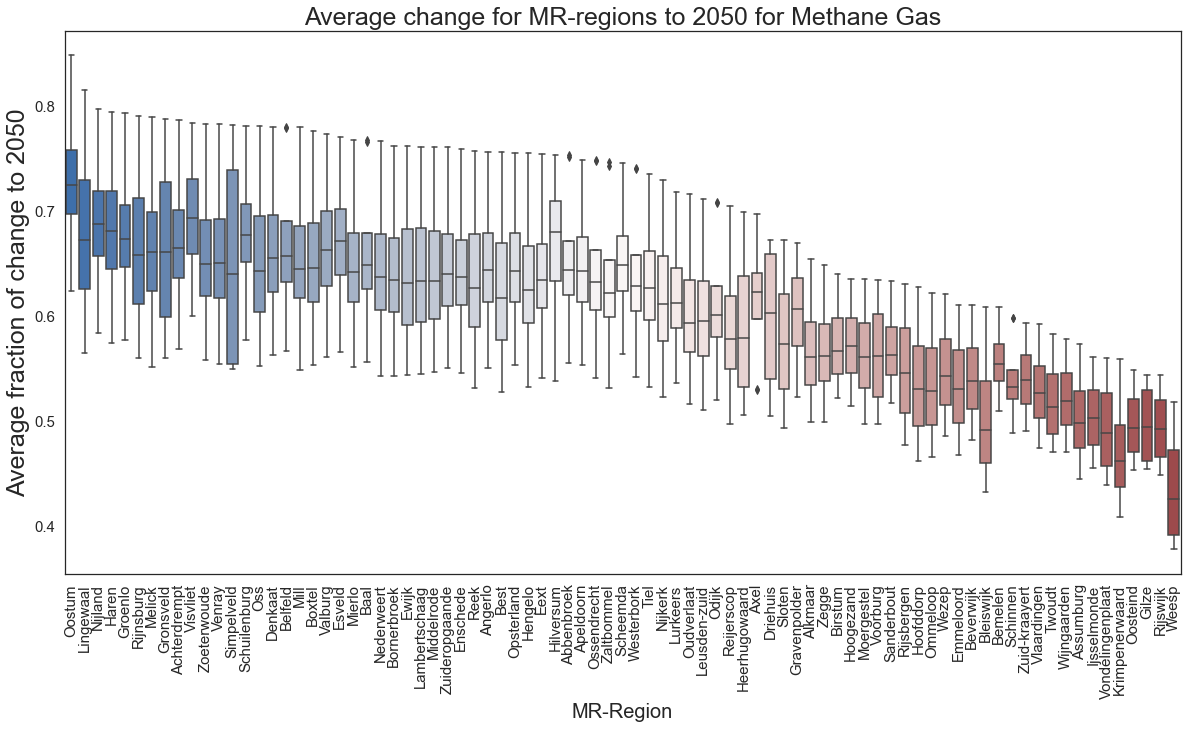

In [549]:
# boxplot for all MR's --> MG change from 2020 to 2050


plt.figure(figsize=(20,10))
plt.tight_layout()

sns.boxplot(x='MR', y='rel_output', 
            data = df_mr_mg.groupby(['MR', 'scenario'], as_index=False).mean().
            sort_values(by='rel_output', ascending=False),
           palette = 'vlag')
plt.xticks(rotation=90, size=15)
plt.yticks(size=15)
plt.ylabel('Average fraction of change to 2050', fontsize = 25)
plt.xlabel('MR-Region', fontsize = 20)
title='Average change for MR-regions to 2050 for Methane Gas'
plt.title(title, fontsize=25)


plotfile = filepath + file + title
plt.savefig(plotfile, dpi=400)

Text(0.5, 1.0, 'Average change for MR-regions to 2050 for Methane Gas')

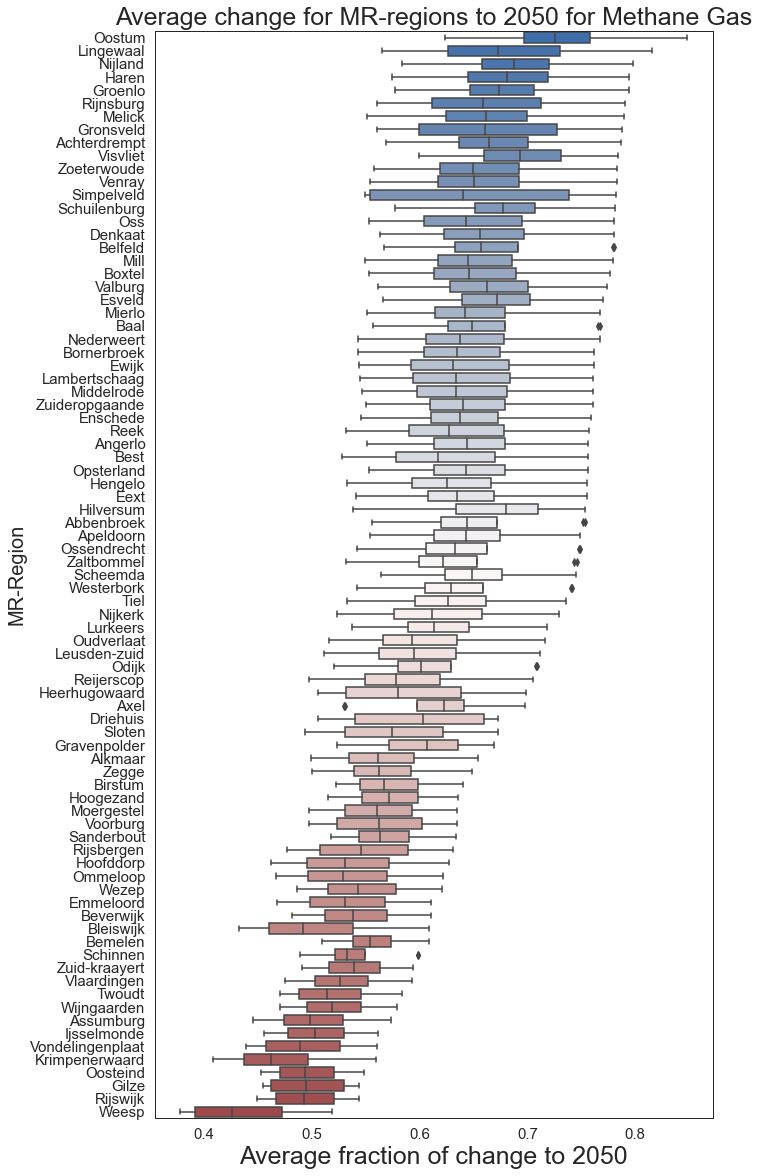

In [609]:
# boxplot for all MR's --> MG change from 2020 to 2050


plt.figure(figsize=(10,20))
plt.tight_layout()

sns.boxplot(x='rel_output', y='MR', 
            data = df_mr_mg.groupby(['MR', 'scenario'], as_index=False).mean().
            sort_values(by='rel_output', ascending=False),
           palette = 'vlag')
plt.xticks(size=15)
plt.yticks(size=15)
plt.xlabel('Average fraction of change to 2050', fontsize = 25)
plt.ylabel('MR-Region', fontsize = 20)
title='Average change for MR-regions to 2050 for Methane Gas'
plt.title(title, fontsize=25)


#plotfile = filepath + file + title
#plt.savefig(plotfile, dpi=400)

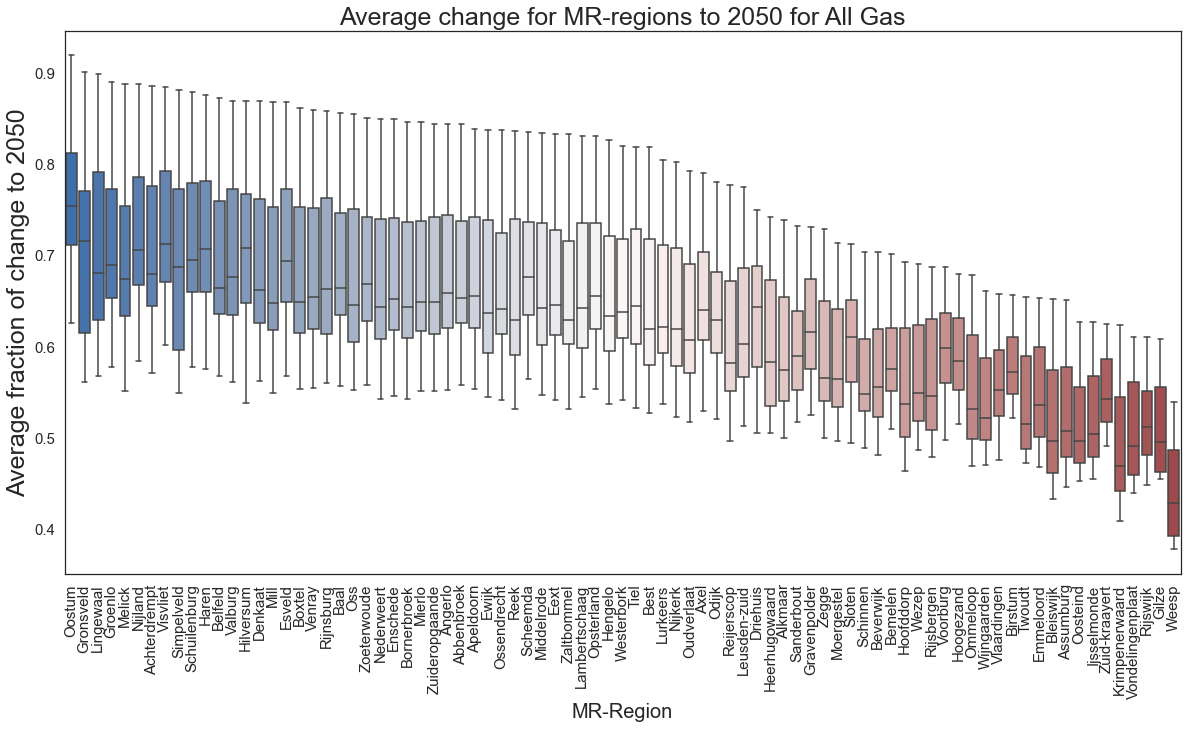

In [550]:
# boxplot for all MR's --> AG change from 2020 to 2050


plt.figure(figsize=(20,10))
plt.tight_layout()

sns.boxplot(x='MR', y='rel_output', 
            data = df_mr_ag.groupby(['MR', 'scenario'], as_index=False).mean().
            sort_values(by='rel_output', ascending=False),
           palette = 'vlag')
plt.xticks(rotation=90, size=15)
plt.yticks(size=15)
plt.ylabel('Average fraction of change to 2050', fontsize = 25)
plt.xlabel('MR-Region', fontsize = 20)
title='Average change for MR-regions to 2050 for All Gas'
plt.title(title, fontsize=25)


plotfile = filepath + file + title
plt.savefig(plotfile, dpi=400)

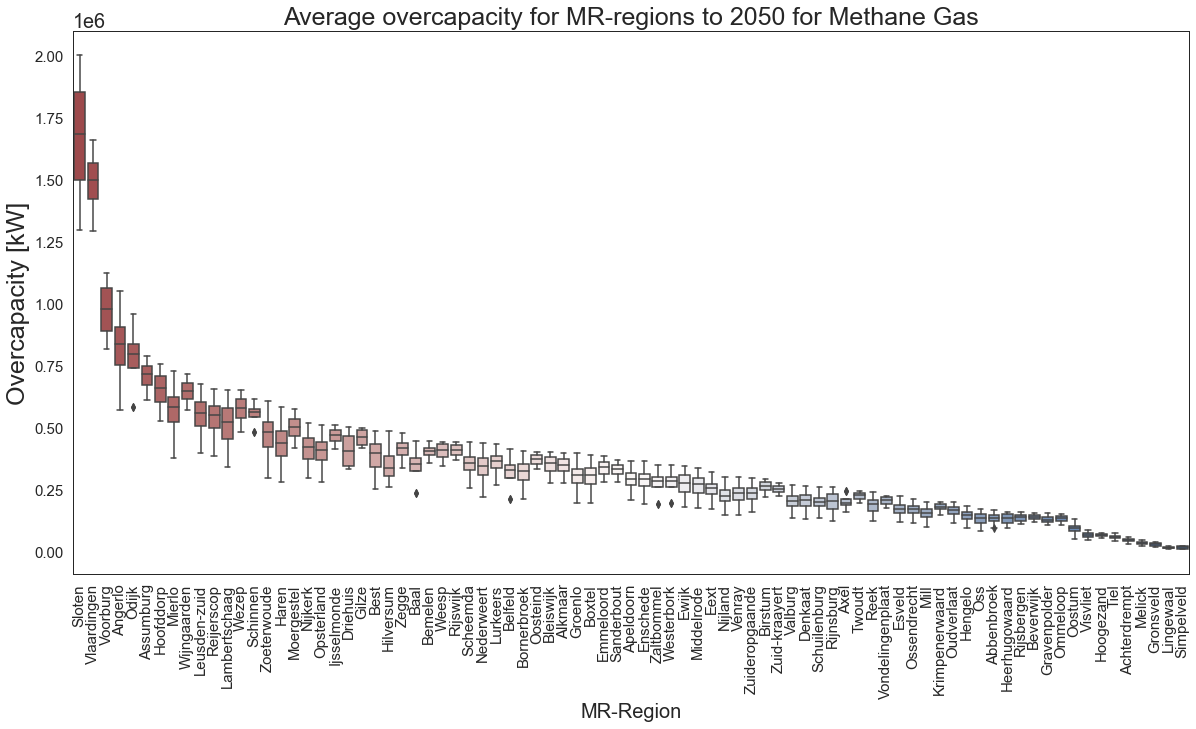

In [589]:
# boxplot for all MR's --> MG change from 2020 to 2050 OVERCAPACITY

plt.figure(figsize=(20,10))
plt.tight_layout()
sns.boxplot(x='MR', y='overcapacity', 
            data = df_mr_mg.groupby(['MR', 'scenario'], as_index=False).mean().
            sort_values(by='overcapacity', ascending=False),
           palette = 'vlag_r')
plt.xticks(rotation=90, size=15)
plt.yticks(size=15)
plt.ylabel('Overcapacity [kW]', fontsize = 25)
plt.xlabel('MR-Region', fontsize = 20)
title = 'Average overcapacity for MR-regions to 2050 for Methane Gas'
plt.title(title, fontsize=25)


plotfile = filepath + file + title
plt.savefig(plotfile, dpi=400)

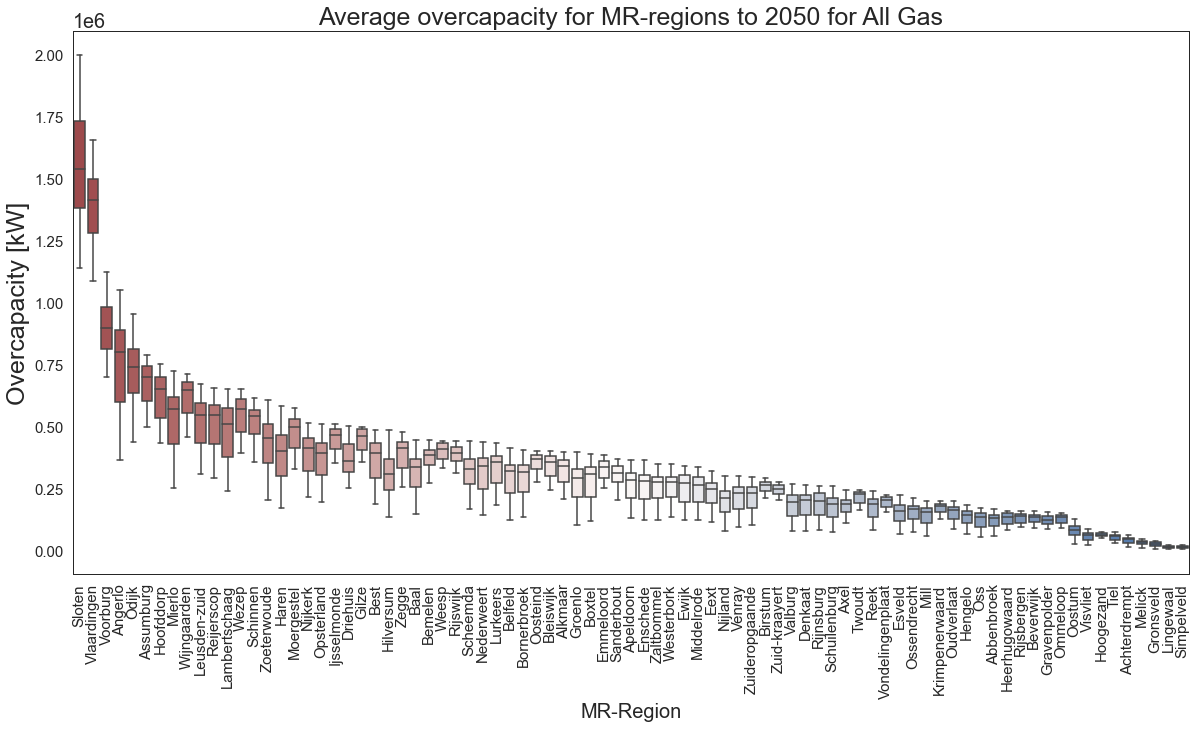

In [590]:
# boxplot for all MR's --> AG change from 2020 to 2050 OVERCAPACITY

plt.figure(figsize=(20,10))
plt.tight_layout()
sns.boxplot(x='MR', y='overcapacity', 
            data = df_mr_ag.groupby(['MR', 'scenario'], as_index=False).mean().
            sort_values(by='overcapacity', ascending=False),
           palette = 'vlag_r')
plt.xticks(rotation=90, size=15)
plt.yticks(size=15)
plt.ylabel('Overcapacity [kW]', fontsize = 25)
plt.xlabel('MR-Region', fontsize = 20)
title = 'Average overcapacity for MR-regions to 2050 for All Gas'
plt.title(title, fontsize=25)


plotfile = filepath + file + title
plt.savefig(plotfile, dpi=400)

Text(0.5, 1.0, 'Average overcapacity from 2020 to 2050 for MR-region: Methane Gas')

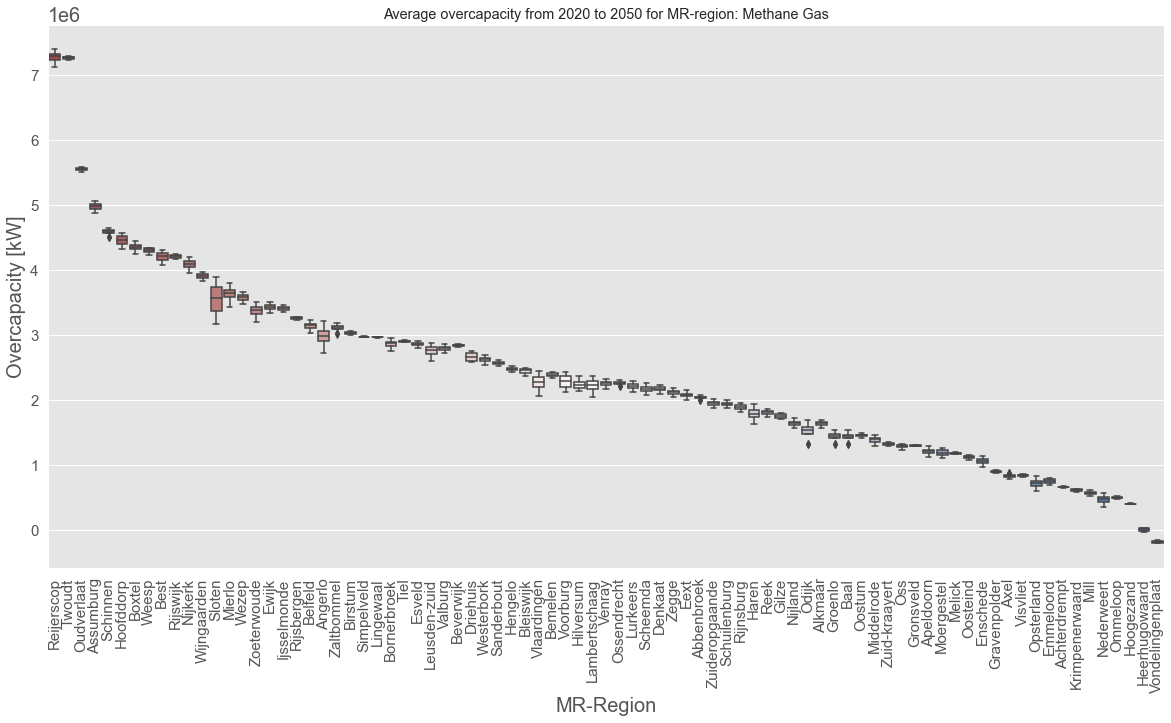

In [577]:
# boxplot for all MR's --> MG change from 2020 to 2050 GASUNIE OVERCAPACITY


plt.figure(figsize=(20,10))
sns.boxplot(x='MR', y='Gasunie_overcapacity', 
            data = df_mr_mg.groupby(['MR', 'scenario'], as_index=False).mean().
            sort_values(by='Gasunie_overcapacity', ascending=False),
           palette = 'vlag_r')
plt.xticks(rotation=90, size=15)
plt.yticks(size=15)
plt.ylabel('Overcapacity [kW]', fontsize = 20)
plt.xlabel('MR-Region', fontsize = 20)
plt.title('Average overcapacity from 2020 to 2050 for MR-region: Methane Gas')

Text(0.5, 1.0, 'Average overcapacity from 2020 to 2050 for MR-region: All Gas')

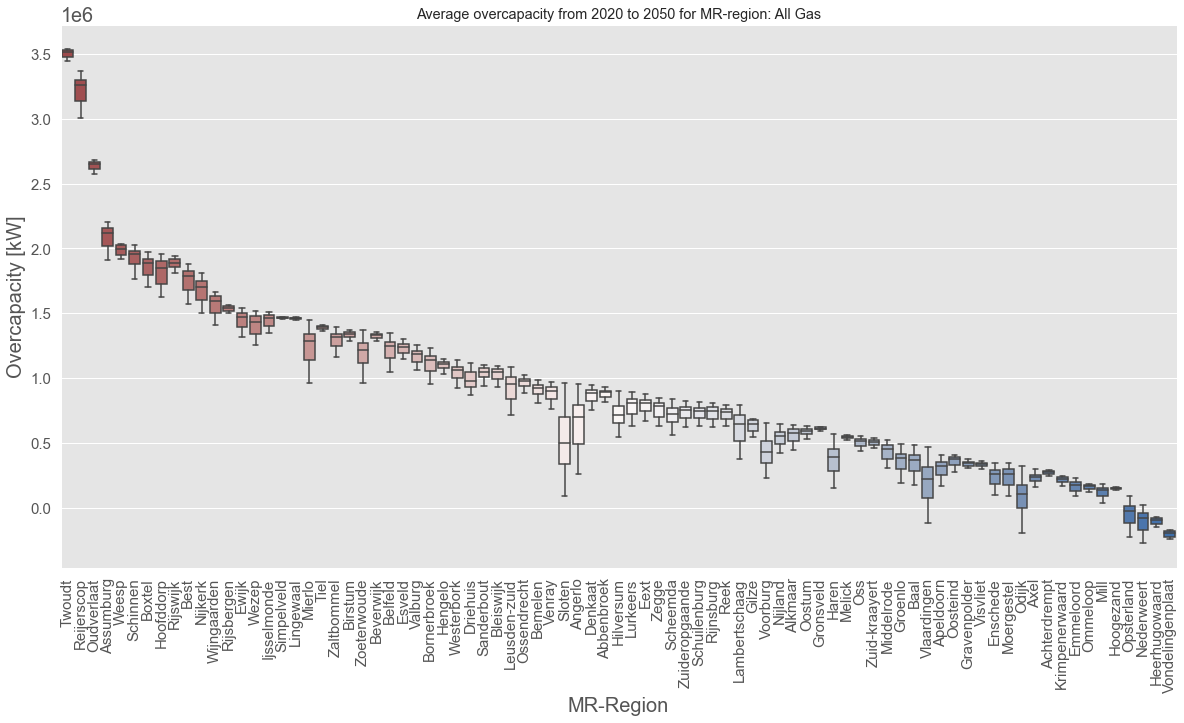

In [578]:
# boxplot for all MR's --> AG change from 2020 to 2050 GASUNIE OVERCAPACITY


plt.figure(figsize=(20,10))
sns.boxplot(x='MR', y='Gasunie_overcapacity', 
            data = df_mr_ag.groupby(['MR', 'scenario'], as_index=False).mean().
            sort_values(by='Gasunie_overcapacity', ascending=False),
           palette = 'vlag_r')
plt.xticks(rotation=90, size=15)
plt.yticks(size=15)
plt.ylabel('Overcapacity [kW]', fontsize = 20)
plt.xlabel('MR-Region', fontsize = 20)
plt.title('Average overcapacity from 2020 to 2050 for MR-region: All Gas')

In [464]:
df_mr_ag_mean_pareto = df_mr_ag.copy()
df_mr_ag_mean_pareto = df_mr_ag_mean_pareto.groupby(['MR'], as_index=False).mean().sort_values(by='overcapacity', ascending=False)
#df_mr_ag_mean_pareto
df_mr_ag_mean_pareto['cumpercentage'] = df_mr_ag_mean_pareto.overcapacity.cumsum()/df_mr_ag_mean_pareto.overcapacity.sum()
#df_mr_ag_mean_pareto.plot(x='MR', y='cumpercentage')

In [362]:
# map with average capacity utilization from built environment resulting from scenarios

municipalities_input['Station 1'] = municipalities_input['Station 1'].str.replace(" ", "").str.lower().str.capitalize()

mp_cap = pd.merge(municipalities_input, MR_CAP, how = 'left', left_on = 'Station 1', right_on = 'Unique stations')
#mr_cap = mp_cap.dissolve(by='Unique stations', as_index=False)
#mr_cap
df_mr_mg_ag_mean = df_mr_mg_ag.groupby(['MR', 'output_type'], as_index=False).mean()
df_mr_mg_ag_cap = pd.merge(mp_cap, df_mr_mg_ag_mean, how = 'left', left_on = 'Station 1', right_on = 'MR')
df_mr_mg_ag_cap

GM_NAAM GM_CODE WATER  AANT_INW  AANTAL_HH Station 1  \
0      Appingedam  GM0003   NEE     11971       5600  Scheemda   
1      Appingedam  GM0003   NEE     11971       5600  Scheemda   
2           Bedum  GM0005   NEE     10479       4399    Oostum   
3           Bedum  GM0005   NEE     10479       4399    Oostum   
4    Bellingwedde  GM0007   NEE      8919       3989  Scheemda   
..            ...     ...   ...       ...        ...       ...   
771   Meierijstad  GM1948   NEE     79864      33611    Boxtel   
772   Montferland  GM1955   NEE     35316      15161   Angerlo   
773   Montferland  GM1955   NEE     35316      15161   Angerlo   
774   Menterwolde  GM1987   NEE     12162       5364  Scheemda   
775   Menterwolde  GM1987   NEE     12162       5364  Scheemda   

                                              geometry Unique stations  \
0    POLYGON ((353839.370 5909783.240, 353842.934 5...        Scheemda   
1    POLYGON ((353839.370 5909783.240, 353842.934 5...        Scheemda   
2    POLYGON ((337192.538 5907060.071, 337194.266 5...          Oostum   
3    POLYGON ((337192.538 5907060.071, 337194.266 5...          Oostum   
4    POLYGON ((367873.097 5886598.533, 367869.490 5...        Scheemda   
..                                                 ...             ...   
771  POLYGON ((250051.381 5725096.529, 250050.949 5...          Boxtel   
772  POLYGON ((304307.023 5754994.503, 304306.372 5...         Angerlo   
773  POLYGON ((304307.023 5754994.503, 304306.372 5...         Angerlo   
774  POLYGON ((354342.520 5896348.752, 354285.594 5...        Scheemda   
775  POLYGON ((354342.520 5896348.752, 354285.594 5...        Scheemda   

     MaxCapGasunieMW_x  RandomCapMW_x        MR  output_type  [step]  \
0             1414.174            NaN  Scheemda      All Gas    2035   
1             1414.174            NaN  Scheemda  Methane Gas    2035   
2              852.739            NaN    Oostum      All Gas    2035   
3              852.739            NaN    Oostum  Methane Gas    2035   
4             1414.174            NaN  Scheemda      All Gas    2035   
..                 ...            ...       ...          ...     ...   
771           2460.280            NaN    Boxtel  Methane Gas    2035   
772           2249.654            NaN   Angerlo      All Gas    2035   
773           2249.654            NaN   Angerlo  Methane Gas    2035   
774           1414.174            NaN  Scheemda      All Gas    2035   
775           1414.174            NaN  Scheemda  Methane Gas    2035   

     MaxCapGasunieMW_y        output  RandomCapMW_y     output_t0  rel_output  \
0             1414.174  6.985916e+05            0.0  1.018964e+06    0.685553   
1             1414.174  6.642675e+05            0.0  1.018964e+06    0.651876   
2              852.739  2.658237e+05            0.0  3.481839e+05    0.763424   
3              852.739  2.544324e+05            0.0  3.481839e+05    0.730709   
4             1414.174  6.985916e+05            0.0  1.018964e+06    0.685553   
..                 ...           ...            ...           ...         ...   
771           2460.280  5.756604e+05            0.0  8.779894e+05    0.655547   
772           2249.654  1.594940e+06            0.0  2.351417e+06    0.678156   
773           2249.654  1.526254e+06            0.0  2.351417e+06    0.648973   
774           1414.174  6.985916e+05            0.0  1.018964e+06    0.685553   
775           1414.174  6.642675e+05            0.0  1.018964e+06    0.651876   

      overcapacity  Gasunie_overcapacity  
0    320372.215264          7.155824e+05  
1    354696.371701          7.499065e+05  
2     82360.140485          5.869153e+05  
3     93751.446828          5.983066e+05  
4    320372.215264          7.155824e+05  
..             ...                   ...  
771  302328.965373          1.884620e+06  
772  756477.184600          6.547145e+05  
773  825162.317586          7.233996e+05  
774  320372.215264          7.155824e+05  
775  354696.37170

In [363]:
# plot MG capacity utilization

df_stripped = df_mr_mg_ag_cap[['GM_NAAM', 'MR', 'MaxCapGasunieMW_x', '[step]', 'output','overcapacity', 'Gasunie_overcapacity','rel_output', 'output_type', 'geometry']]
#df_meanovertime = df_stripped.groupby(['GM_NAAM', 'MR', 'output_type', 'geometry'], as_index=False).mean()
df_meanovertime_mg = df_stripped[df_stripped['output_type'] == 'Methane Gas']
df_meanovertime_ag = df_stripped[df_stripped.output_type == 'All Gas']

#type(df_meanovertime_mg)

df_meanovertime_mg_dissolved = df_meanovertime_mg.dissolve(by='MR', as_index=False)
df_meanovertime_ag_dissolved = df_meanovertime_ag.dissolve(by='MR', as_index=False)

In [364]:
df_mr_mg_ag[df_mr_mg_ag.MR == 'Vlaardingen']

[step] scenario           MR  MaxCapGasunieMW        output  \
71       2020       G1  Vlaardingen         1972.105  3.178311e+06   
154      2020       G2  Vlaardingen         1972.105  3.158580e+06   
237      2020       G3  Vlaardingen         1972.105  3.178311e+06   
320      2020       G4  Vlaardingen         1972.105  3.158580e+06   
403      2020       G5  Vlaardingen         1972.105  3.178311e+06   
...       ...      ...          ...              ...           ...   
20240    2050       G4  Vlaardingen         1972.105  1.865463e+05   
20323    2050       G5  Vlaardingen         1972.105  6.071044e+05   
20406    2050       G6  Vlaardingen         1972.105  5.499664e+04   
20489    2050       G7  Vlaardingen         1972.105  8.619763e+05   
20572    2050       G8  Vlaardingen         1972.105  1.951257e+05   

       RandomCapMW  output_type     output_t0  rel_output  overcapacity  \
71             0.0      All Gas  3.178311e+06    1.000000  0.000000e+00   
154            0.0      All Gas  3.158580e+06    1.000000  0.000000e+00   
237            0.0      All Gas  3.178311e+06    1.000000  0.000000e+00   
320            0.0      All Gas  3.158580e+06    1.000000  0.000000e+00   
403            0.0      All Gas  3.178311e+06    1.000000  0.000000e+00   
...            ...          ...           ...         ...           ...   
20240          0.0  Methane Gas  3.158580e+06    0.059060  2.972034e+06   
20323          0.0  Methane Gas  3.178311e+06    0.191015  2.571207e+06   
20406          0.0  Methane Gas  3.158580e+06    0.017412  3.103584e+06   
20489          0.0  Methane Gas  3.178311e+06    0.271206  2.316335e+06   
20572          0.0  Methane Gas  3.158580e+06    0.061776  2.963455e+06   

       Gasunie_overcapacity  
71            -1.206206e+06  
154           -1.186475e+06  
237           -1.206206e+06  
320           -1.186475e+06  
403           -1.206206e+06  
...                     ...  
20240          1.785559e+06  
20323          1.365001e+06  
20406          1.917108e+06  
20489          1.110129e+06  
20572          1.776979e+06  

[496 rows x 11 columns]

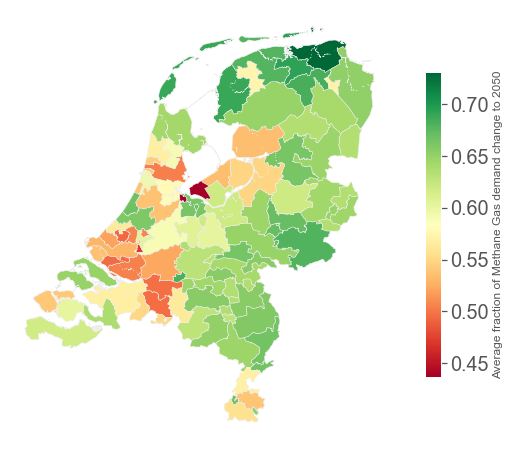

In [573]:
title = "Average fraction of Methane Gas demand change to 2050"
df_meanovertime_mg_dissolved.plot(column='rel_output', legend = 'True', cmap = 'RdYlGn', 
                                  legend_kwds={'shrink': 0.7, 
                                               'label': title,
                                               'orientation': "vertical"}).set_axis_off()

plotfile = filepath + file + title + " MAP"
plt.savefig(plotfile, dpi=400)

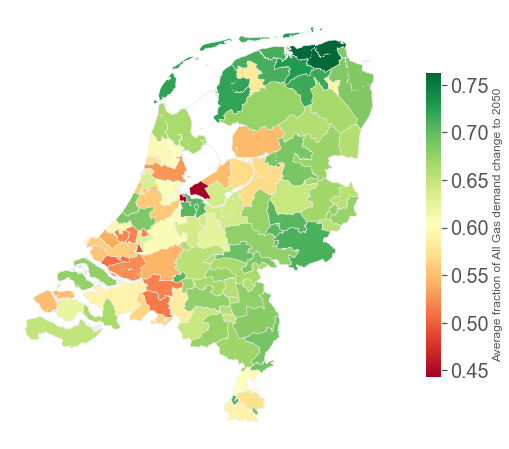

In [574]:
title = "Average fraction of All Gas demand change to 2050"
df_meanovertime_ag_dissolved.plot(column='rel_output', legend = 'True', cmap = 'RdYlGn', 
                                  legend_kwds={'shrink': 0.7, 
                                               'label': title,
                                               'orientation': "vertical"}).set_axis_off()

plotfile = filepath + file + title + " MAP"
plt.savefig(plotfile, dpi=400)

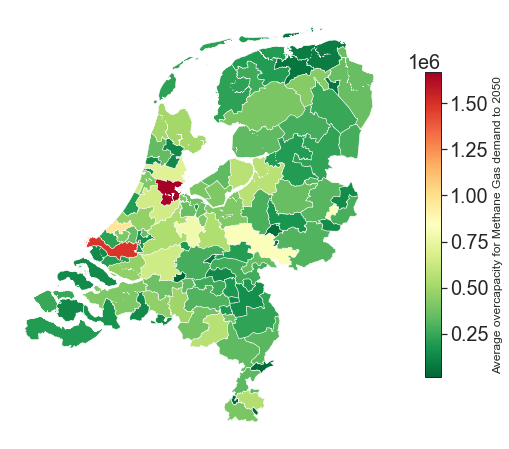

In [594]:
title = "Average overcapacity for Methane Gas demand to 2050"
df_meanovertime_mg_dissolved.plot(column='overcapacity', legend = 'True', cmap = 'RdYlGn_r', 
                                  legend_kwds={'shrink': 0.7, 
                                               'label': title,
                                               'orientation': "vertical"}).set_axis_off()

plotfile = filepath + file + title + " MAP"
plt.savefig(plotfile, dpi=400)

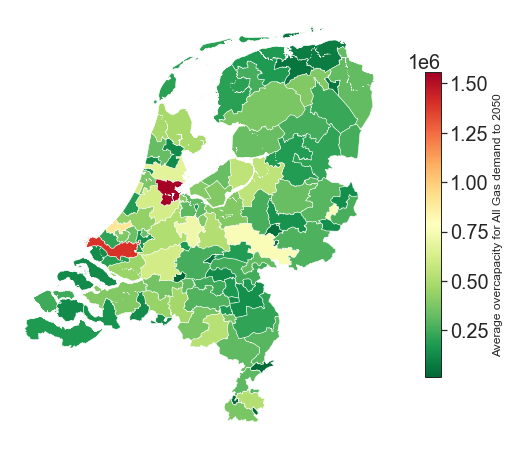

In [595]:
title = "Average overcapacity for All Gas demand to 2050"
df_meanovertime_ag_dissolved.plot(column='overcapacity', legend = 'True', cmap = 'RdYlGn_r', 
                                  legend_kwds={'shrink': 0.7, 
                                               'label': title,
                                               'orientation': "vertical"}).set_axis_off()

plotfile = filepath + file + title + " MAP"
plt.savefig(plotfile, dpi=400)

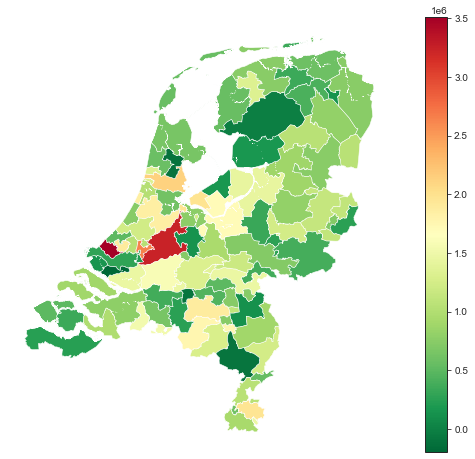

In [369]:
df_meanovertime_mg_dissolved.plot(column='Gasunie_overcapacity', legend = 'full', cmap = 'RdYlGn_r').set_axis_off()

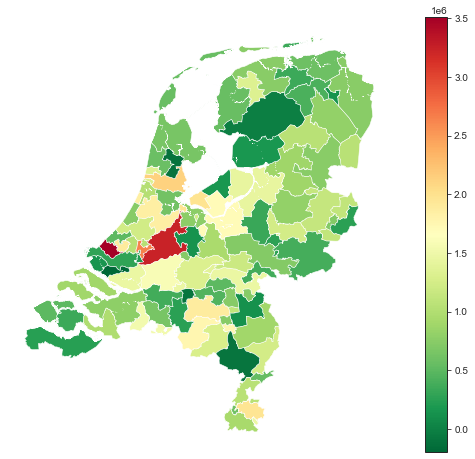

In [370]:
df_meanovertime_mg_dissolved.plot(column='Gasunie_overcapacity', legend = 'full', cmap = 'RdYlGn_r').set_axis_off()

In [190]:
# spread of cap utilization per MR


[step] scenario              MR        output  output_type  \
0        2020       G1      Abbenbroek  3.879801e+05      All Gas   
1        2020       G1    Achterdrempt  1.443474e+05      All Gas   
2        2020       G1         Alkmaar  8.035593e+05      All Gas   
3        2020       G1         Angerlo  2.355829e+06      All Gas   
4        2020       G1       Apeldoorn  8.304577e+05      All Gas   
...       ...      ...             ...           ...          ...   
20579    2050       G8      Zaltbommel  1.263122e+05  Methane Gas   
20580    2050       G8           Zegge  1.004040e+05  Methane Gas   
20581    2050       G8     Zoeterwoude  2.352115e+05  Methane Gas   
20582    2050       G8   Zuid-kraayert  4.106669e+04  Methane Gas   
20583    2050       G8  Zuideropgaande  1.046793e+05  Methane Gas   

          output_t0  rel_output  
0      3.879801e+05    1.000000  
1      1.443474e+05    1.000000  
2      8.035593e+05    1.000000  
3      2.355829e+06    1.000000  
4      8.304577e+05    1.000000  
...             ...         ...  
20579  7.499251e+05    0.168433  
20580  9.547548e+05    0.105162  
20581  1.375470e+06    0.171005  
20582  5.480022e+05    0.074939  
20583  6.616627e+05    0.158206  

[41168 rows x 7 columns]

In [213]:
df_boxplots = pd.merge(df_mr_mg_ag, MR_CAP, how = 'left', left_on = 'MR', right_on = 'Unique stations')
df_boxplots['output_MW'] = df_boxplots['output'] / 1000
df_boxplots['Gasunie_cap_util'] = df_boxplots['output_MW'] / df_boxplots['MaxCapGasunieMW']

df_boxplots

[step] scenario              MR        output  output_type  \
0        2020       G1      Abbenbroek  3.879801e+05      All Gas   
1        2020       G1    Achterdrempt  1.443474e+05      All Gas   
2        2020       G1         Alkmaar  8.035593e+05      All Gas   
3        2020       G1         Angerlo  2.355829e+06      All Gas   
4        2020       G1       Apeldoorn  8.304577e+05      All Gas   
...       ...      ...             ...           ...          ...   
41163    2050       G8      Zaltbommel  1.263122e+05  Methane Gas   
41164    2050       G8           Zegge  1.004040e+05  Methane Gas   
41165    2050       G8     Zoeterwoude  2.352115e+05  Methane Gas   
41166    2050       G8   Zuid-kraayert  4.106669e+04  Methane Gas   
41167    2050       G8  Zuideropgaande  1.046793e+05  Methane Gas   

          output_t0  rel_output Unique stations  MaxCapGasunieMW  RandomCapMW  \
0      3.879801e+05    1.000000      Abbenbroek         1143.074          NaN   
1      1.443474e+05    1.000000    Achterdrempt          377.081          NaN   
2      8.035593e+05    1.000000         Alkmaar         1041.581          NaN   
3      2.355829e+06    1.000000         Angerlo         2249.654          NaN   
4      8.304577e+05    1.000000       Apeldoorn          868.529          NaN   
...             ...         ...             ...              ...          ...   
41163  7.499251e+05    0.168433      Zaltbommel         1790.029          NaN   
41164  9.547548e+05    0.105162           Zegge         1327.616          NaN   
41165  1.375470e+06    0.171005     Zoeterwoude         2136.682          NaN   
41166  5.480022e+05    0.074939   Zuid-kraayert          807.185          NaN   
41167  6.616627e+05    0.158206  Zuideropgaande         1187.094          NaN   

         output_MW  Gasunie_cap_util  
0       387.980130          0.339418  
1       144.347395          0.382802  
2       803.559324          0.771480  
3      2355.828715          1.047196  
4       830.457662          0.956166  
...            ...               ...  
41163   126.312242          0.070564  
41164   100.403994          0.075627  
41165   235.211542          0.110083  
41166    41.066692          0.050876  
41167   104.679309          0.088181  

[41168 rows x 12 columns]

(0.0, 3.0)

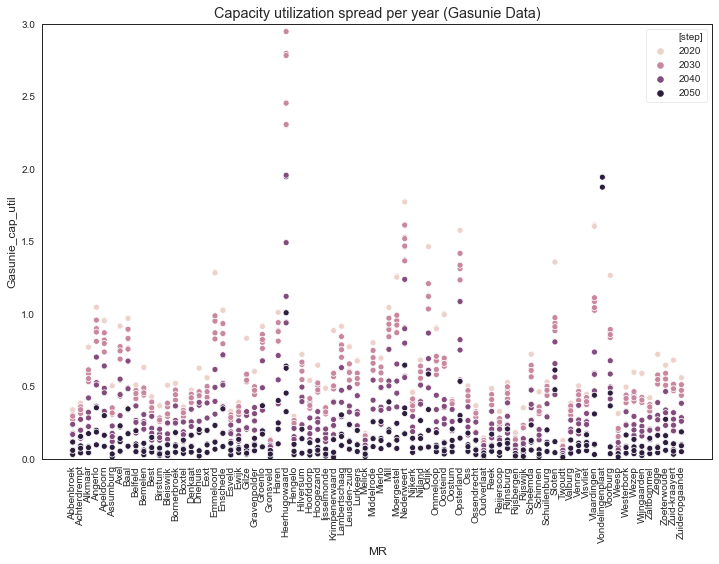

In [214]:
gas = 'Methane Gas'
sns.scatterplot(x='MR', y='Gasunie_cap_util', hue = '[step]',
                data = df_boxplots[((df_boxplots['[step]'] == 2020) |
                                                         (df_boxplots['[step]'] == 2030) |
                                                         (df_boxplots['[step]'] == 2040) |
                                                         (df_boxplots['[step]'] == 2050)) &
                                                         (df_boxplots['output_type'] == gas)])
plt.title('Capacity utilization spread per year (Gasunie Data)')
plt.xticks(rotation=90)
plt.ylim(0, 3)

(0.0, 3.0)

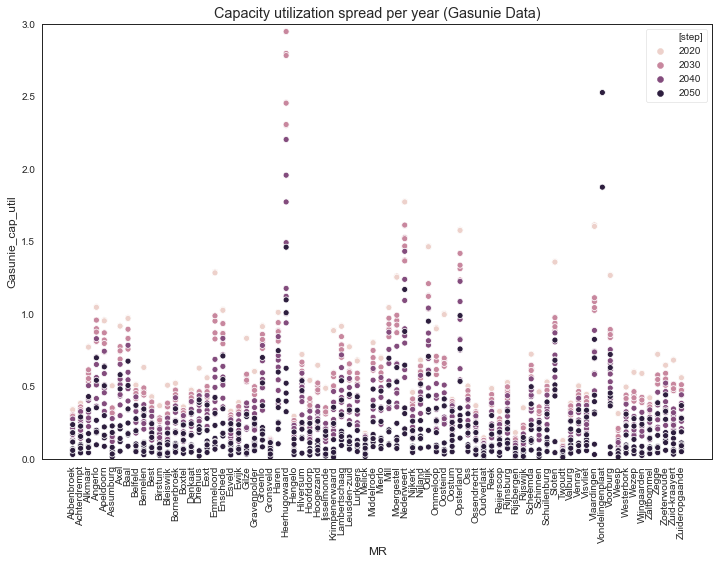

In [216]:
gas = 'All Gas'
sns.scatterplot(x='MR', y='Gasunie_cap_util', hue = '[step]',
                data = df_boxplots[((df_boxplots['[step]'] == 2020) |
                                                         (df_boxplots['[step]'] == 2030) |
                                                         (df_boxplots['[step]'] == 2040) |
                                                         (df_boxplots['[step]'] == 2050)) &
                                                         (df_boxplots['output_type'] == gas)])
plt.title('Capacity utilization spread per year (Gasunie Data)')
plt.xticks(rotation=90)
plt.ylim(0, 3)

(0.0, 1.0)

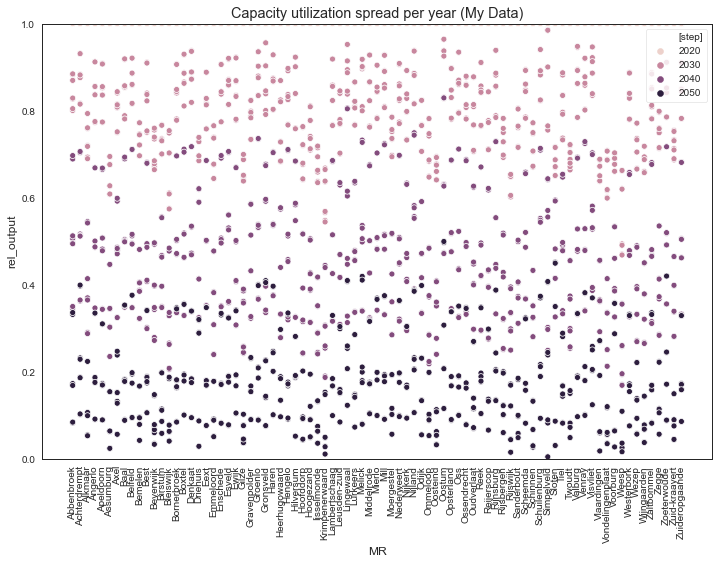

In [218]:
gas = 'Methane Gas'
sns.scatterplot(x='MR', y='rel_output', hue = '[step]',
                data = df_boxplots[((df_boxplots['[step]'] == 2020) |
                                                         (df_boxplots['[step]'] == 2030) |
                                                         (df_boxplots['[step]'] == 2040) |
                                                         (df_boxplots['[step]'] == 2050)) &
                                                         (df_boxplots['output_type'] == gas)])
plt.title('Capacity utilization spread per year (My Data)')
plt.xticks(rotation=90)
plt.ylim(0, 1)

(0.0, 1.0)

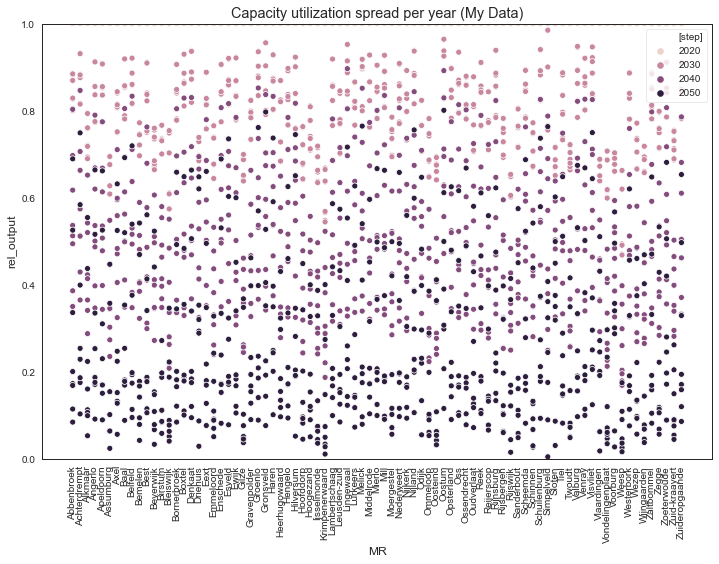

In [219]:
gas = 'All Gas'
sns.scatterplot(x='MR', y='rel_output', hue = '[step]',
                data = df_boxplots[((df_boxplots['[step]'] == 2020) |
                                                         (df_boxplots['[step]'] == 2030) |
                                                         (df_boxplots['[step]'] == 2040) |
                                                         (df_boxplots['[step]'] == 2050)) &
                                                         (df_boxplots['output_type'] == gas)])
plt.title('Capacity utilization spread per year (My Data)')
plt.xticks(rotation=90)
plt.ylim(0, 1)

In [388]:
# TOP 5 TABELLEN

In [392]:
# MOST AVERAGE DECLINE
df_mr_mg.groupby('MR').mean().sort_values(by='rel_output', ascending=True)[:5]

[step]  MaxCapGasunieMW         output  RandomCapMW  \
MR                                                                      
Weesp               2035         2303.516  314050.245018          0.0   
Krimpenerwaard      2035          385.501  161071.565490          0.0   
Rijswijk            2035         2302.654  399407.308645          0.0   
Vondelingenplaat    2035            7.380  200874.725219          0.0   
Gilze               2035         1104.361  455726.701897          0.0   

                      output_t0  rel_output   overcapacity  \
MR                                                           
Weesp             718023.133746    0.437152  403972.888728   
Krimpenerwaard    340724.120646    0.472662  179652.555156   
Rijswijk          808034.453839    0.494198  408627.145194   
Vondelingenplaat  405990.580067    0.494690  205115.854848   
Gilze             917438.457216    0.496680  461711.755319   

                  Gasunie_overcapacity  
MR                                      
Weesp                     1.989466e+06  
Krimpenerwaard            2.244294e+05  
Rijswijk                  1.903247e+06  
Vondelingenplaat         -1.934947e+05  
Gilze                     6.486343e+05

In [393]:
df_mr_ag.groupby('MR').mean().sort_values(by='rel_output', ascending=True)[:5]

[step]  MaxCapGasunieMW         output  RandomCapMW  \
MR                                                                      
Weesp               2035         2303.516  318574.682430          0.0   
Krimpenerwaard      2035          385.501  167685.497013          0.0   
Vondelingenplaat    2035            7.380  206589.205301          0.0   
Gilze               2035         1104.361  471579.187303          0.0   
Oosteind            2035          740.530  382767.823885          0.0   

                      output_t0  rel_output   overcapacity  \
MR                                                           
Weesp             718023.133746    0.443434  399448.451316   
Krimpenerwaard    340724.120646    0.492054  173038.623634   
Vondelingenplaat  405990.580067    0.508743  199401.374766   
Gilze             917438.457216    0.513934  445859.269913   
Oosteind          738271.672561    0.518281  355503.848676   

                  Gasunie_overcapacity  
MR                                      
Weesp                     1.984941e+06  
Krimpenerwaard            2.178155e+05  
Vondelingenplaat         -1.992092e+05  
Gilze                     6.327818e+05  
Oosteind                  3.577622e+05

In [395]:
# LEAST AVERAGE DECLINE
df_mr_mg.groupby('MR').mean().sort_values(by='rel_output', ascending=False)[:5]

[step]  MaxCapGasunieMW         output  RandomCapMW     output_t0  \
MR                                                                             
Oostum       2035          852.739  254432.443480          0.0  3.481839e+05   
Visvliet     2035          494.092  152192.652696          0.0  2.193758e+05   
Nijland      2035         1068.801  501106.427213          0.0  7.268220e+05   
Haren        2035         1361.172  938255.716303          0.0  1.374045e+06   
Lingewaal    2035         1500.000   36838.129064          0.0  5.402037e+04   

           rel_output   overcapacity  Gasunie_overcapacity  
MR                                                          
Oostum       0.730709   93751.446828          5.983066e+05  
Visvliet     0.693669   67183.104487          3.418993e+05  
Nijland      0.689376  225715.562995          5.676946e+05  
Haren        0.682794  435789.502460          4.229163e+05  
Lingewaal    0.681872   17182.241436          1.463162e+06

In [396]:
df_mr_ag.groupby('MR').mean().sort_values(by='rel_output', ascending=False)[:5]

[step]  MaxCapGasunieMW         output  RandomCapMW  \
MR                                                                  
Oostum          2035          852.739  265823.749822          0.0   
Visvliet        2035          494.092  159908.387418          0.0   
Nijland         2035         1068.801  524062.853455          0.0   
Haren           2035         1361.172  984699.712973          0.0   
Schuilenburg    2035         1179.726  444546.974102          0.0   

                 output_t0  rel_output   overcapacity  Gasunie_overcapacity  
MR                                                                           
Oostum        3.481839e+05    0.763424   82360.140485         586915.250178  
Visvliet      2.193758e+05    0.728816   59467.369766         334183.612582  
Nijland       7.268220e+05    0.720944  202759.136752         544738.146545  
Haren         1.374045e+06    0.716589  389345.505790         376472.287027  
Schuilenburg  6.242525e+05    0.712000  179705.553969         735179.025898

In [397]:
# LEAST AVERAGE OVERCAPACITY
df_mr_mg.groupby('MR').mean().sort_values(by='overcapacity', ascending=True)[:5]

[step]  MaxCapGasunieMW        output  RandomCapMW  \
MR                                                                 
Lingewaal       2035         1500.000  36838.129064          0.0   
Simpelveld      2035         1500.000  33004.626276          0.0   
Gronsveld       2035          677.427  62188.341328          0.0   
Melick          2035          623.353  72289.518607          0.0   
Achterdrempt    2035          377.081  96863.604195          0.0   

                  output_t0  rel_output  overcapacity  Gasunie_overcapacity  
MR                                                                           
Lingewaal      54020.370500    0.681872  17182.241436          1.463162e+06  
Simpelveld     50553.301407    0.652858  17548.675131          1.466995e+06  
Gronsveld      93217.657826    0.667106  31029.316498          6.152387e+05  
Melick        108627.850506    0.665437  36338.331899          5.510635e+05  
Achterdrempt  144248.050072    0.671468  47384.445877          2.802174e+05

In [398]:
df_mr_ag.groupby('MR').mean().sort_values(by='overcapacity', ascending=True)[:5]

[step]  MaxCapGasunieMW         output  RandomCapMW  \
MR                                                                  
Simpelveld      2035         1500.000   34904.351542          0.0   
Lingewaal       2035         1500.000   38159.878188          0.0   
Gronsveld       2035          677.427   66110.581332          0.0   
Melick          2035          623.353   75213.195933          0.0   
Achterdrempt    2035          377.081  101613.940199          0.0   

                  output_t0  rel_output  overcapacity  Gasunie_overcapacity  
MR                                                                           
Simpelveld     50553.301407    0.690428  15648.949865          1.465096e+06  
Lingewaal      54020.370500    0.706326  15860.492312          1.461840e+06  
Gronsveld      93217.657826    0.709171  27107.076494          6.113164e+05  
Melick        108627.850506    0.692335  33414.654573          5.481398e+05  
Achterdrempt  144248.050072    0.704388  42634.109872          2.754671e+05

In [401]:
# MOST AVERAGE OVERCAPACITY
df_mr_mg.groupby('MR').mean().sort_values(by='overcapacity', ascending=False)[:5]

[step]  MaxCapGasunieMW        output  RandomCapMW     output_t0  \
MR                                                                              
Sloten         2035         2917.674  2.290232e+06          0.0  3.959139e+06   
Vlaardingen    2035         1972.105  1.679530e+06          0.0  3.168446e+06   
Voorburg       2035         1770.221  1.263248e+06          0.0  2.239330e+06   
Angerlo        2035         2249.654  1.526254e+06          0.0  2.351417e+06   
Odijk          2035         1366.453  1.215502e+06          0.0  1.999108e+06   

             rel_output  overcapacity  Gasunie_overcapacity  
MR                                                           
Sloten         0.578393  1.668906e+06         627441.565568  
Vlaardingen    0.529969  1.488916e+06         292575.321318  
Voorburg       0.564058  9.760817e+05         506973.211023  
Angerlo        0.648973  8.251623e+05         723399.619059  
Odijk          0.607961  7.836067e+05         150951.291003

In [400]:
df_mr_ag.groupby('MR').mean().sort_values(by='overcapacity', ascending=False)[:5]

[step]  MaxCapGasunieMW        output  RandomCapMW     output_t0  \
MR                                                                              
Sloten         2035         2917.674  2.402125e+06          0.0  3.959139e+06   
Vlaardingen    2035         1972.105  1.773886e+06          0.0  3.168446e+06   
Voorburg       2035         1770.221  1.333082e+06          0.0  2.239330e+06   
Angerlo        2035         2249.654  1.594940e+06          0.0  2.351417e+06   
Odijk          2035         1366.453  1.278118e+06          0.0  1.999108e+06   

             rel_output  overcapacity  Gasunie_overcapacity  
MR                                                           
Sloten         0.606665  1.557014e+06         515549.340879  
Vlaardingen    0.559739  1.394560e+06         198218.730668  
Voorburg       0.595250  9.062473e+05         437138.828474  
Angerlo        0.678156  7.564772e+05         654714.486073  
Odijk          0.639277  7.209904e+05          88335.010242

In [610]:
# top 3 analysis

/Users/jaromirbogdanovski/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3062: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


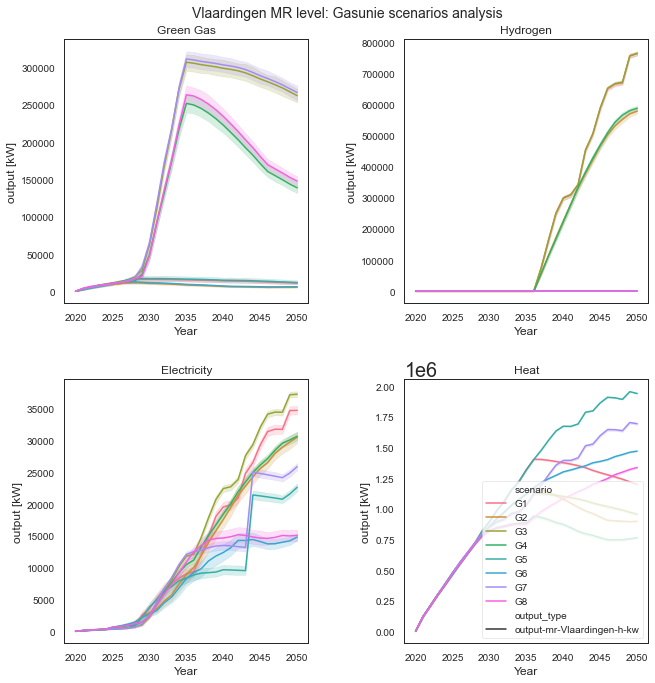

In [623]:
# mr level

mr_kpi = 'Vlaardingen'

# selected MR

# MR level boxplot: 
# subset df_melted to contain only mr's
sns.set_style('white')
fig, ((ax0, ax1), (ax2, ax3)) = plt.subplots(nrows = 2, ncols = 2, figsize = (10,10))
fig.tight_layout(pad=4)
title = mr_kpi + ' MR level: Gasunie scenarios analysis'
fig.suptitle(title, fontsize = 14)

df_mr = df_melted[(df_melted.output_type.str.contains('output-mr')) & df_melted.output_type.str.contains('-kw')
                 & (df_melted.output_type != 'output-mp-ng-kw') & (df_melted.output_type != 'output-mp-gg-kw')
                 & (df_melted.output_type != 'output-mp-h2-kw') & (df_melted.output_type != 'output-mp-e-kw')
                 & (df_melted.output_type != 'output-mp-h-kw')]


df_mr[['output']] = df_mr[['output']].apply(pd.to_numeric).copy()
#df_mr_select = df_mr[(df_mr.output_type.str.contains('output-mr-Rotterdam')) | (df_mr[df_mr.output_type.str.contains('output-mr-Vlaardingen')])] 
#                    (df_mr[df_mr.output_type.str.contains('output-mr-Schiedam')]) |
#                    (df_mr[df_mr.output_type.str.contains('output-mr-Maassluis')])]

df_mr_select = df_mr[(df_mr.output_type.str.contains(mr_kpi, regex=True))]

x_line = '[step]'
x_box = 'output_type'
y = 'output'

sns.lineplot(ax = ax0, x=x_line, y=y, hue = 'scenario', legend = False, style = 'output_type', err_style = 'band', data = df_mr_select[df_mr_select.output_type.str.contains('gg-kw')])
ax0.set(ylabel='output [kW]', xlabel = 'Year')
ax0.set_title('Green Gas', fontsize = 12)
ax0.tick_params(labelsize=10)

sns.lineplot(ax = ax1, x=x_line, y=y, hue = 'scenario', legend = False, style = 'output_type', err_style = 'band', data = df_mr_select[df_mr_select.output_type.str.contains('h2-kw')])
ax1.set(ylabel='output [kW]', xlabel = 'Year')
ax1.set_title('Hydrogen', fontsize = 12)
ax1.tick_params(labelsize=10)

sns.lineplot(ax = ax2, x=x_line, y=y, hue = 'scenario', legend = False, style = 'output_type', err_style = 'band', data = df_mr_select[df_mr_select.output_type.str.contains('e-kw')])
ax2.set(ylabel='output [kW]', xlabel = 'Year')
ax2.set_title('Electricity', fontsize = 12)
ax2.tick_params(labelsize=10)

sns.lineplot(ax = ax3, x=x_line, y=y, hue = 'scenario', style = 'output_type', err_style = 'band', data = df_mr_select[df_mr_select.output_type.str.contains('h-kw')])
ax3.set(ylabel='output [kW]', xlabel = 'Year')
ax3.legend(loc='lower right', fontsize = 10)
ax3.set_title('Heat', fontsize = 12)
ax3.tick_params(labelsize=10)

mr_file = filepath + file + "mr_" + mr_kpi
fig.savefig(mr_file)